# Plotting and Curve Fitting Real Data

*We will use various modules to plot, manipulate, and fit astronomical data.  In addition, a primer on random numbers concludes this part.*

   Section A: [Radio Recombination Lines in the Galactic Center](#sectionA)

   Section B: [Using Data from Bubbles in the Milky Way](#sectionB)

   Section C: [Zooinverse Galaxy Zoo Data](#sectionC)
   
   Section D: [Random Numbers](#sectionD)

***
<a id='sectionA'></a>
## A. Radio Recombination Lines in the Galactic Center

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/Center_of_the_Milky_Way_Galaxy_IV_%E2%80%93_Composite.jpg/1920px-Center_of_the_Milky_Way_Galaxy_IV_%E2%80%93_Composite.jpg" width = "800x">

The [center of the Milky Way Galaxy](https://en.wikipedia.org/wiki/Galactic_Center) is 27,000 light years from our solar system and harbors a [4 million solar mass super massive black hole](https://en.wikipedia.org/wiki/Sagittarius_A*).  Despite the presence of this black hole, [star formation appears to still be occurring](https://arxiv.org/abs/0905.2161).  Evidence of such star formation is available in the surrounding gas which appears ionized due to radiation from bright young stellar objects.

Ionized gas consists of a soup of protons and electrons that are continuously recombining (and reionizing).  When an electron recombines with a proton it typically starts in a highly energetic state rather than immediately landing in the ground state.  The electron then cascades down one energy level at a time until it finds itself in the ground state (and eventually gets reionized). 

However, each time the electron moves down one energy level a photon is emitted that we can observe (called recombination lines).  We will use data from such an observation to measure the velocity of the gas.

In [1]:
# Load the modules we will need
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd  # we will use a pandas dataframe for this example

The data we will use is of the [mini-spiral](http://www.astro.ucla.edu/~ghezgroup/gc/journey/dynamicGas.shtml) of the Galactic Center.  The mini-spiral is a collection of ionized gas 'streamers' that are oribiting the super massive black hole.  The observation is from [ALMA](https://almascience.nrao.edu/), a giant array of 12-m antennas in Chile.


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/The_Atacama_Compact_Array.jpg/1920px-The_Atacama_Compact_Array.jpg" width = "800x">


In [2]:
# Use read_csv from pandas to read in the data as a dataframe
# Note that we need to ignore comments from the datafile
spectra = pd.read_csv('data/h30a_gc.txt', delim_whitespace=True, comment='#', header=None)

# The first column is in units of (km/s).
# The second column is in units of (Jy), we will find this to be 
# more convinient in units of (mJy)

# convert Jy to mJy
spectra[1] = spectra[1]*10**3  

`H30a_gc.txt` refers to the galactic center (gc) at a frequency (~230 GHz) which corresponds to the photon that is emitted from an electron moving down one (alpha) energy level in hydrogen (H) gas from n=30.

<IPython.core.display.Javascript object>


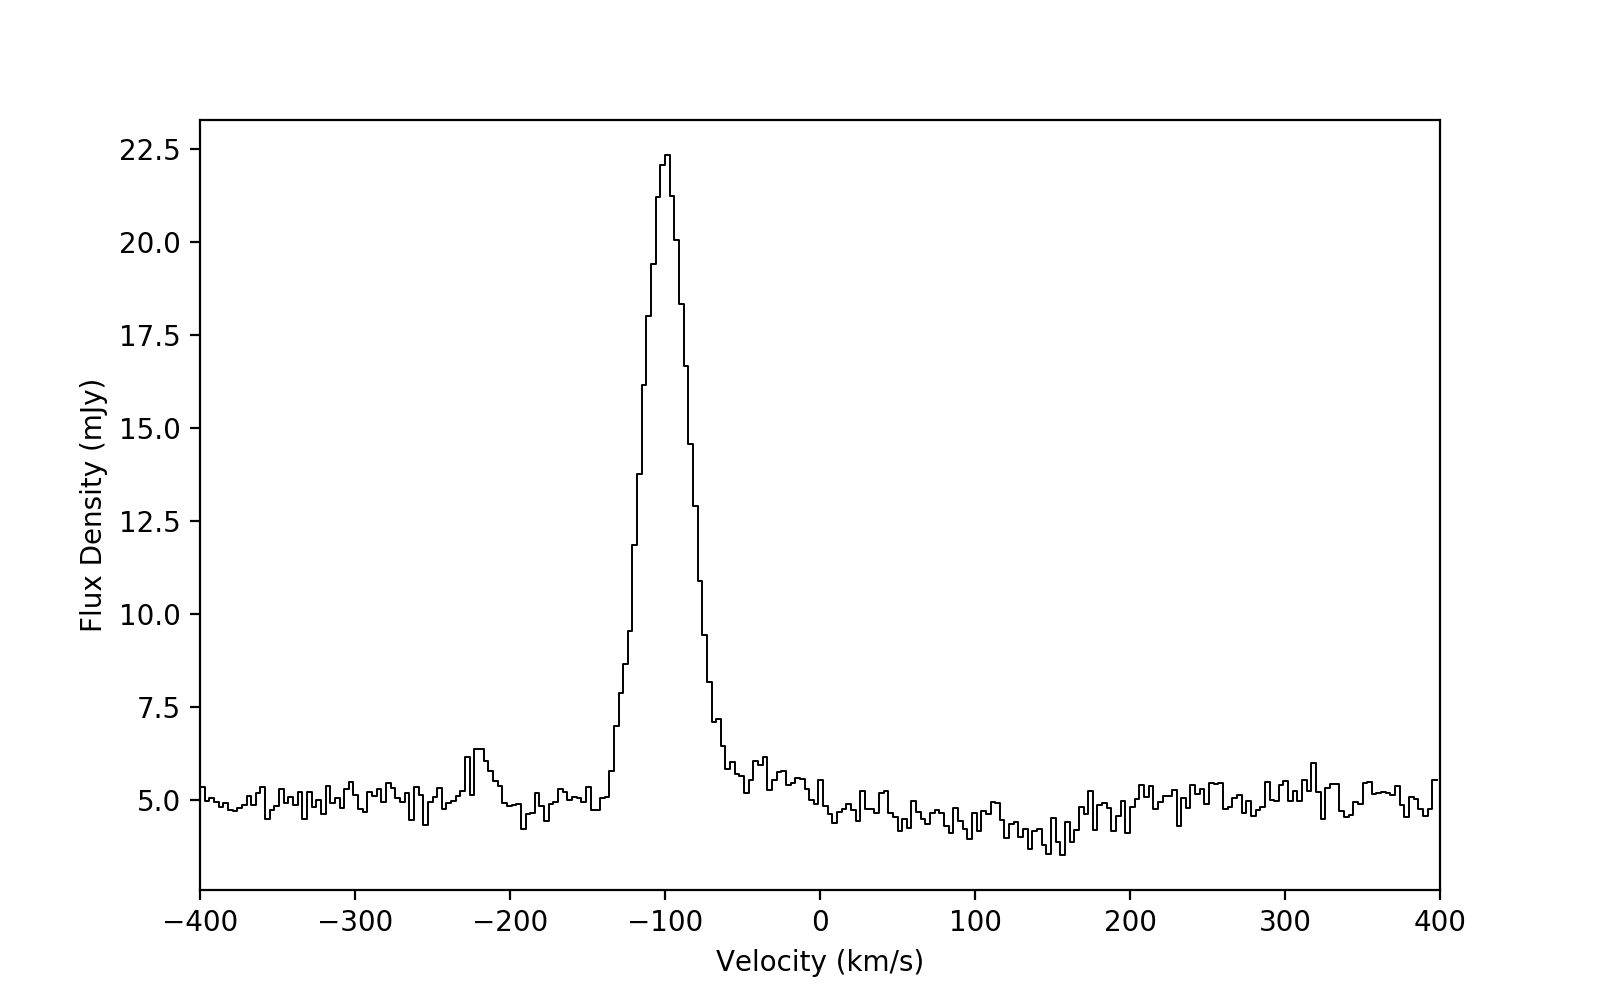

In [3]:
# Now we can plot the data.
f,ax = plt.subplots(figsize=(8,5))

ax.step(spectra[0],spectra[1],'k', linewidth=0.7)
ax.set_xlim(-400,400)
ax.set_xlabel('Velocity (km/s)')
ax.set_ylabel('Flux Density (mJy)')

Note that we used `step` to plot rather than `plot`.  This is useful for spectra as each y-value is effectively a count (in this case intensity) for the corresponding bin - similar to a histogram.

Now we will want to fit the data with a curve.  Obviously a simple line won't work this time! However, the emission line does look Gaussian (or Normal).  But wait! Before we can directly fit this line though we need to subtract out the 'continuum'.

Remember that the line emission we see is due to electrons changning energy levels that was captured by a proton.  Often times though a free electron will interact with a proton but not actually get captured.  When this happens the force between the two particles causes an acceleration in the electron which in turn causes a photon to be emitted.  This is called [Bremsstrahlung](https://en.wikipedia.org/wiki/Bremsstrahlung) or free-free emission because both particles are free before and after the interaction.

The continuum we see is (in part) a result of this free-free emission because it can emit at any frequency.  However, since it detracts from what we are interested in (the recombination line emission) we will want to subtract it out.

It can be approximately modelled as linear, particularily for the data we have.  Thus, we can use the same technique used previously with `curve_fit` but with one catch: we must not include the emission line when fitting the continuum

In [4]:
# first lets define a linear function as done in part 1
def linModel(x,m,b):
    return m*x+b

Now, using the above plot which range of velocities do we want to fit the continuum to? 

In [6]:
# lets go with -400<v<-150 AND 0<v<400
# we can use np.where to find the index where these velocities are

# use the '&' operand insde of the np.where argument to constrain the regions
contInd_reg1 = np.where((spectra[0]>-400) & (spectra[0]<-150))[0]
contInd_reg2 = np.where((spectra[0]>0) & (spectra[0]<400))[0]
contInd = np.concatenate((contInd_reg1,contInd_reg2))  #putting together the two 'regions'

# now lets input this into linModel
# make sure you are only selecting the above region
fitCoeffs, fitCovariances = curve_fit(linModel, spectra[0][contInd], spectra[1][contInd])

bestfit_m = fitCoeffs[0]
bestfit_b = fitCoeffs[1]

Now that we have modelled the continuum, we need to subract it from the real continuum so that we are left with data that contains the line emission only.

<IPython.core.display.Javascript object>


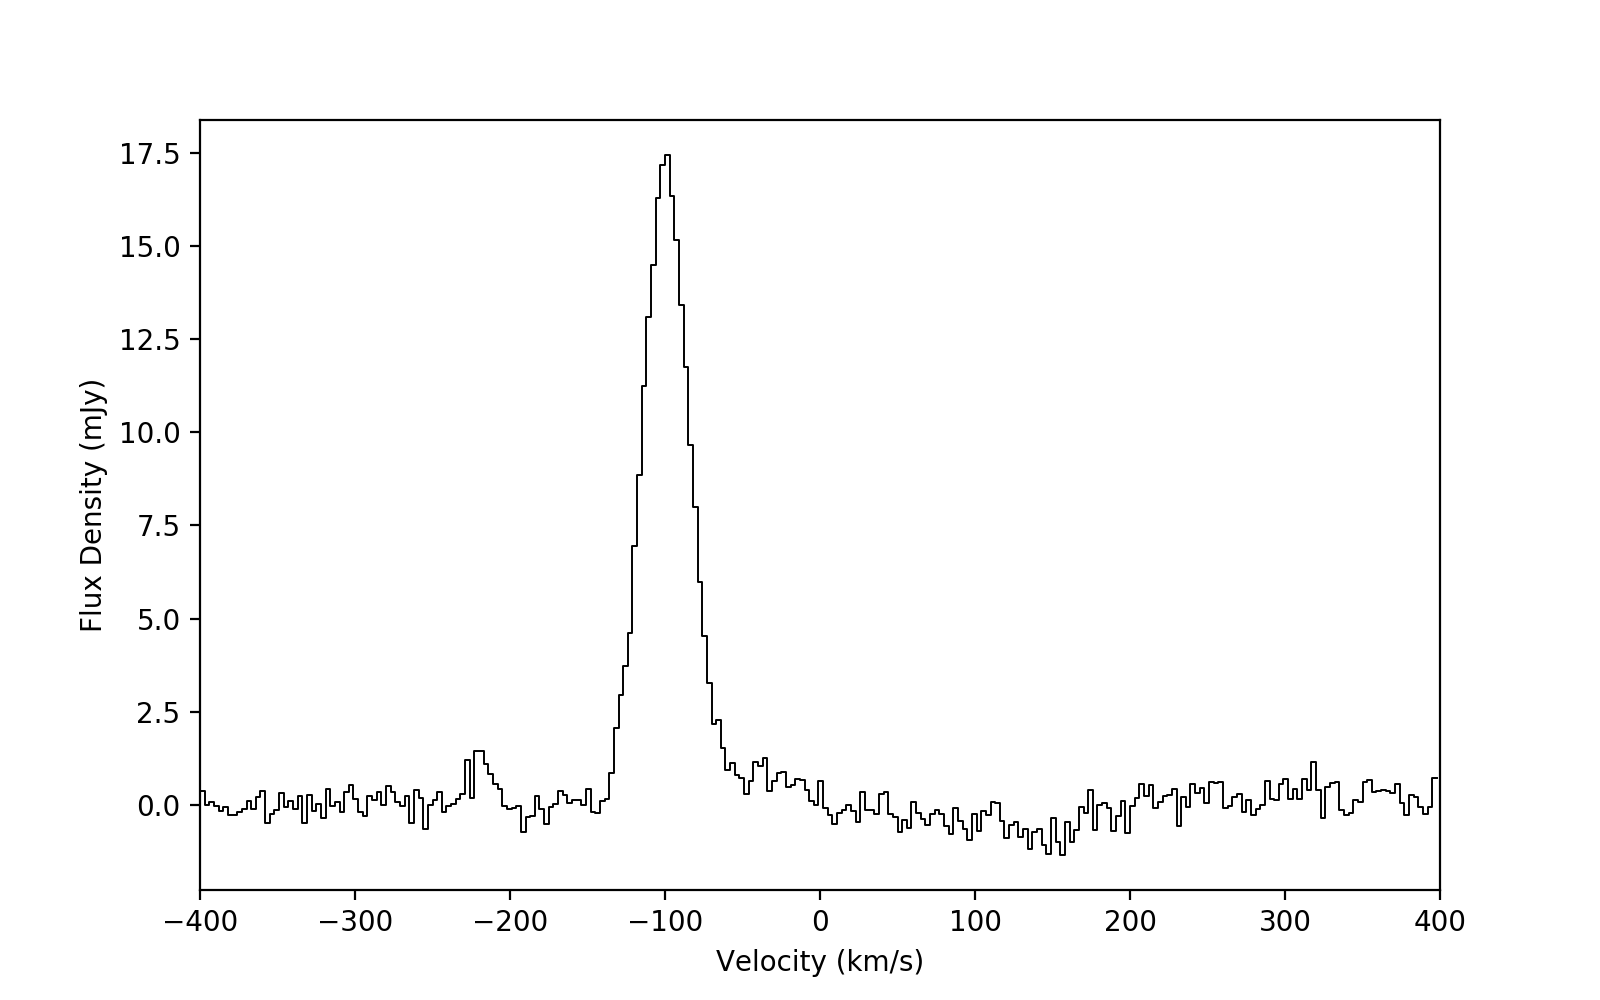

In [10]:
# get the modelled continuum
contModel = linModel(spectra[0], bestfit_m, bestfit_b)
# subtract it from the data
contFree = spectra[1]-contModel

# now another plot to make sure it looks OK
# same as above but use 'contFree' instead of spectra[1]
f,ax = plt.subplots(figsize=(8,5))

ax.step(spectra[0],contFree,'k', linewidth=0.7)
ax.set_xlim(-400,400)
ax.set_xlabel('Velocity (km/s)')
ax.set_ylabel('Flux Density (mJy)')

Notice the continuum level now.  Hopefully its at zero now?  If so good, then we can get what we are actually after - the emission line.  Which as perviously mentioned we are going to model as a Gaussian.

If we assume that the zero level of the Gaussian is at 0 (which we can safely do now that we subtracted the continuum), we can model the spectrum with the expression:

$$ y = I_0 e^{-4\ln{2} \alpha^2}$$
where,
$$ \alpha = \frac{x-v_0}{w}. $$

Here $I_0$ is the peak intensity, $v_0$ is the position of the peak intensity, and $w$ is the full width at half maximum (FWHM).

Similar to the line fit, we will need to define a function for a Gaussian before using `curve_fit`.

In [12]:
# Lets make a function describing a gaussian for curve_fit
def gauss(x, *params):
    peak, vel, fwhm = params
    y = peak*np.exp(-4*np.log(2)*(x-vel)**2/fwhm**2)
                    
    return y

Last time we used `curve_fit` we were able to let the function use a default set of initial guesses.  However, this time the function is much more complicated so we will have to make a guess first.  Use our initial plot of the spectrum to make a guess of the fit parameters.

In [13]:
# p0 should be a list (or tuple) with our intial guesses of the three parameters
p0 = [17,-100,20]

# now we can try to fit the data
fitCoeffs, fitCov = curve_fit(gauss, spectra[0], contFree, p0=p0)

<IPython.core.display.Javascript object>


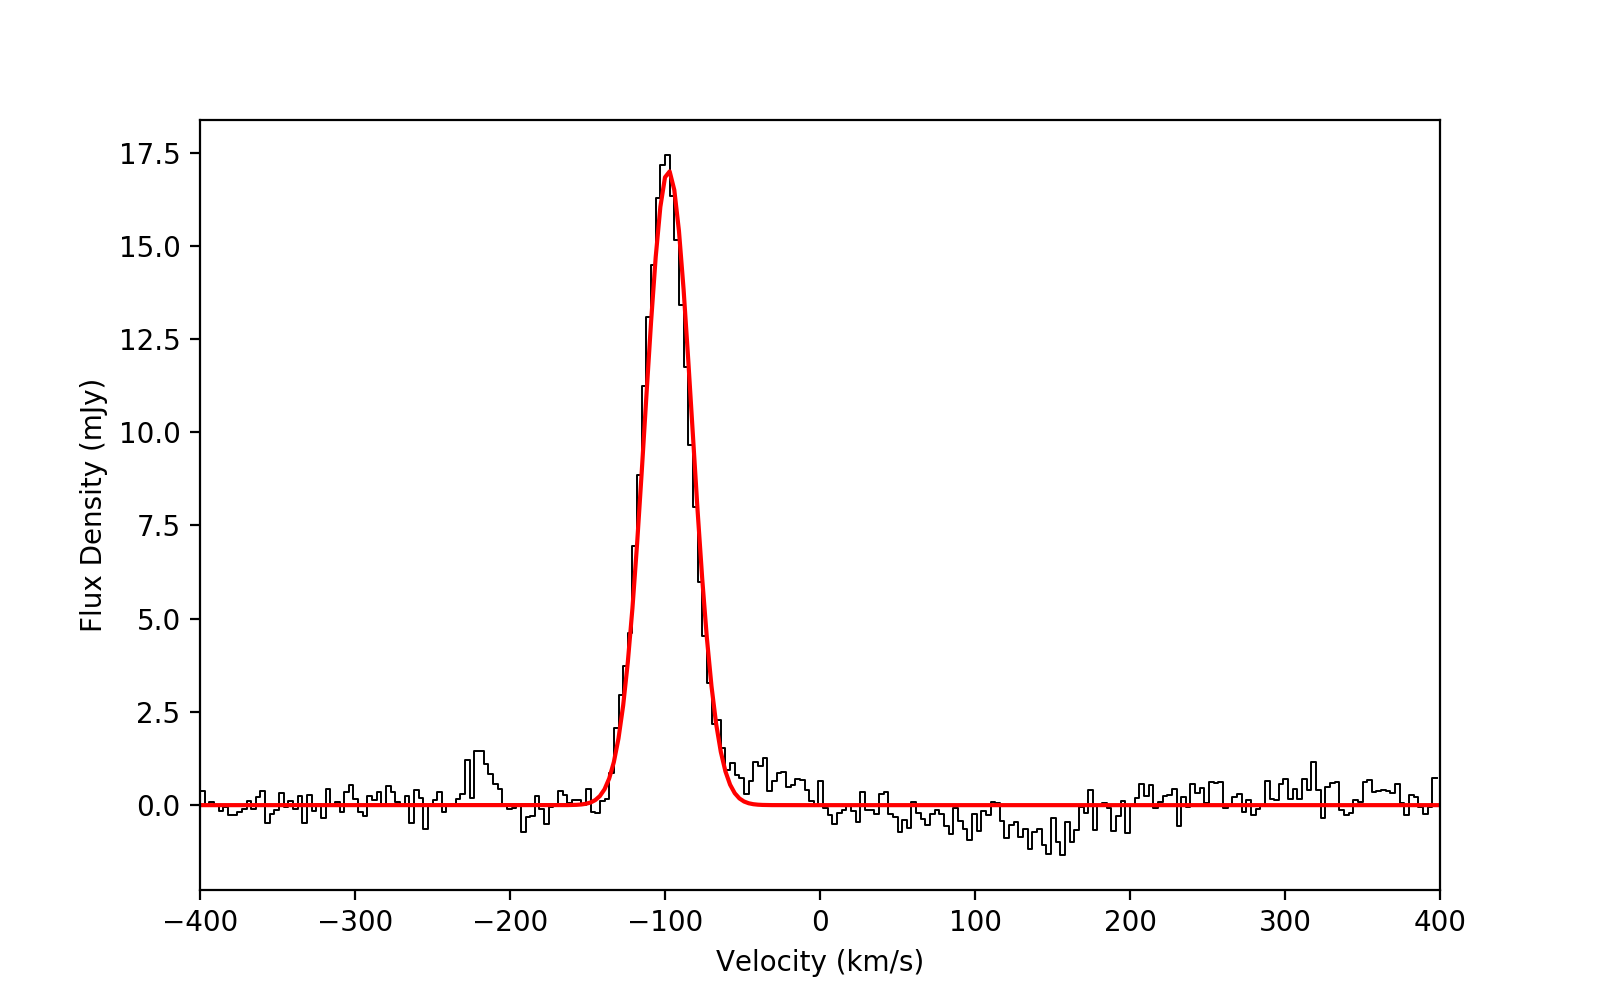

In [14]:
# lets plot the data again along with the fit to see if things look OK
f,ax = plt.subplots(figsize=(8,5))

ax.step(spectra[0],contFree,'k', linewidth=0.7)
ax.set_xlim(-400,400)
ax.set_xlabel('Velocity (km/s)')
ax.set_ylabel('Flux Density (mJy)')

# don't forget the fit
ax.plot(spectra[0], gauss(spectra[0], *fitCoeffs), 'r')

In [18]:
# getting the results of each parameter
peak = fitCoeffs[0]
vel = fitCoeffs[1]
fwhm = fitCoeffs[2]

peakErr = np.sqrt(fitCov[0][0])
velErr = np.sqrt(fitCov[1][1])
fwhmErr = np.sqrt(fitCov[2][2])

print(f'The peak intensity is : {peak:5.3} +/-{peakErr:4.1} mJy')
print(f'The center velocity is: {vel:5.3} +/-{velErr:4.1} km/s')
print(f'The FWHM is           : {fwhm:5.3} +/-{fwhmErr:4.1} km/s')

The peak intensity is :  17.0 +/- 0.2 mJy
The center velocity is: -97.8 +/- 0.2 km/s
The FWHM is           :  35.7 +/- 0.5 km/s


The quality of the data (and the fit) can be visualized by plotting the residual.  This is simply the difference between the fit and the data.

<IPython.core.display.Javascript object>


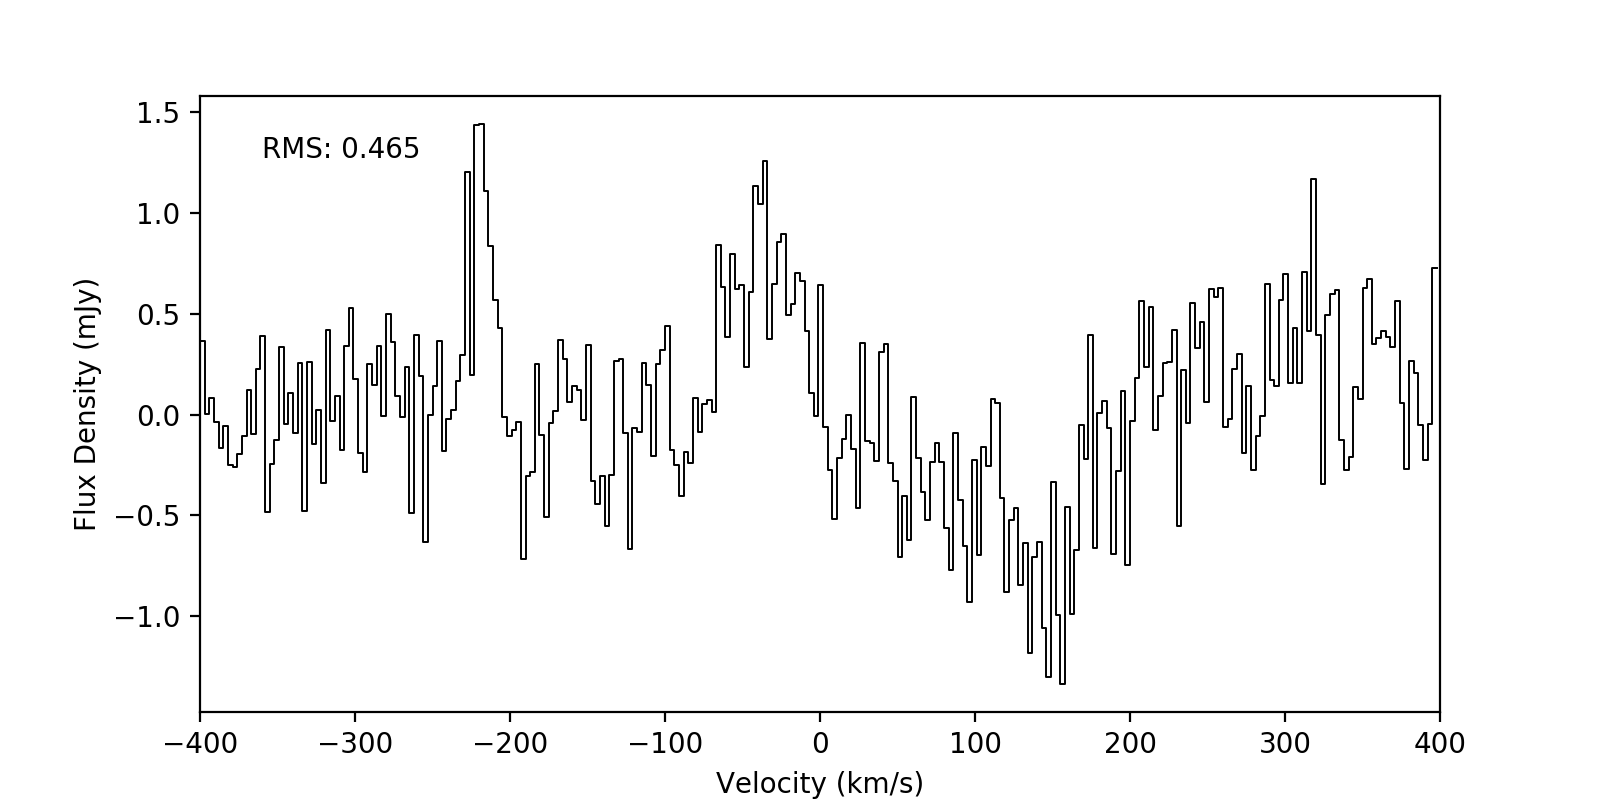

In [19]:
# subtract the fit from the data
residual = contFree - gauss(spectra[0], *fitCoeffs)

# get the rms/standard deviation
std = np.round(np.std(residual),3)
rms = 'RMS: ' + str(std)

# and plot
f,ax = plt.subplots(figsize=(8,4))

ax.step(spectra[0], residual,'k', linewidth=0.7)
ax.text(0.05,0.9,rms,transform=ax.transAxes) # print out the rms on the plot
# make sure to add labels
ax.set_xlim(-400,400)
ax.set_xlabel('Velocity (km/s)')
ax.set_ylabel('Flux Density (mJy)')

#### Exercise!
Load up a different spectrum, 'data/h30a_gc_2comp.txt'.  This spectrum contains multiple (two) emission lines.  Perform the same analysis as above to fit both Gaussian components.  Plot and and print your results.  You don't have to subtract the continuum as it has already been done for this spectrum.   (*Further challenge: Can you write your code to work for an arbitary number of emission lines?*)

In [96]:
# use as many cells as you need.
spectra_new = pd.read_csv('data/h30a_gc_2comp.txt', delim_whitespace=True, comment='#', header=None)

spectra_new[1] = spectra_new[1]*10**3

<IPython.core.display.Javascript object>


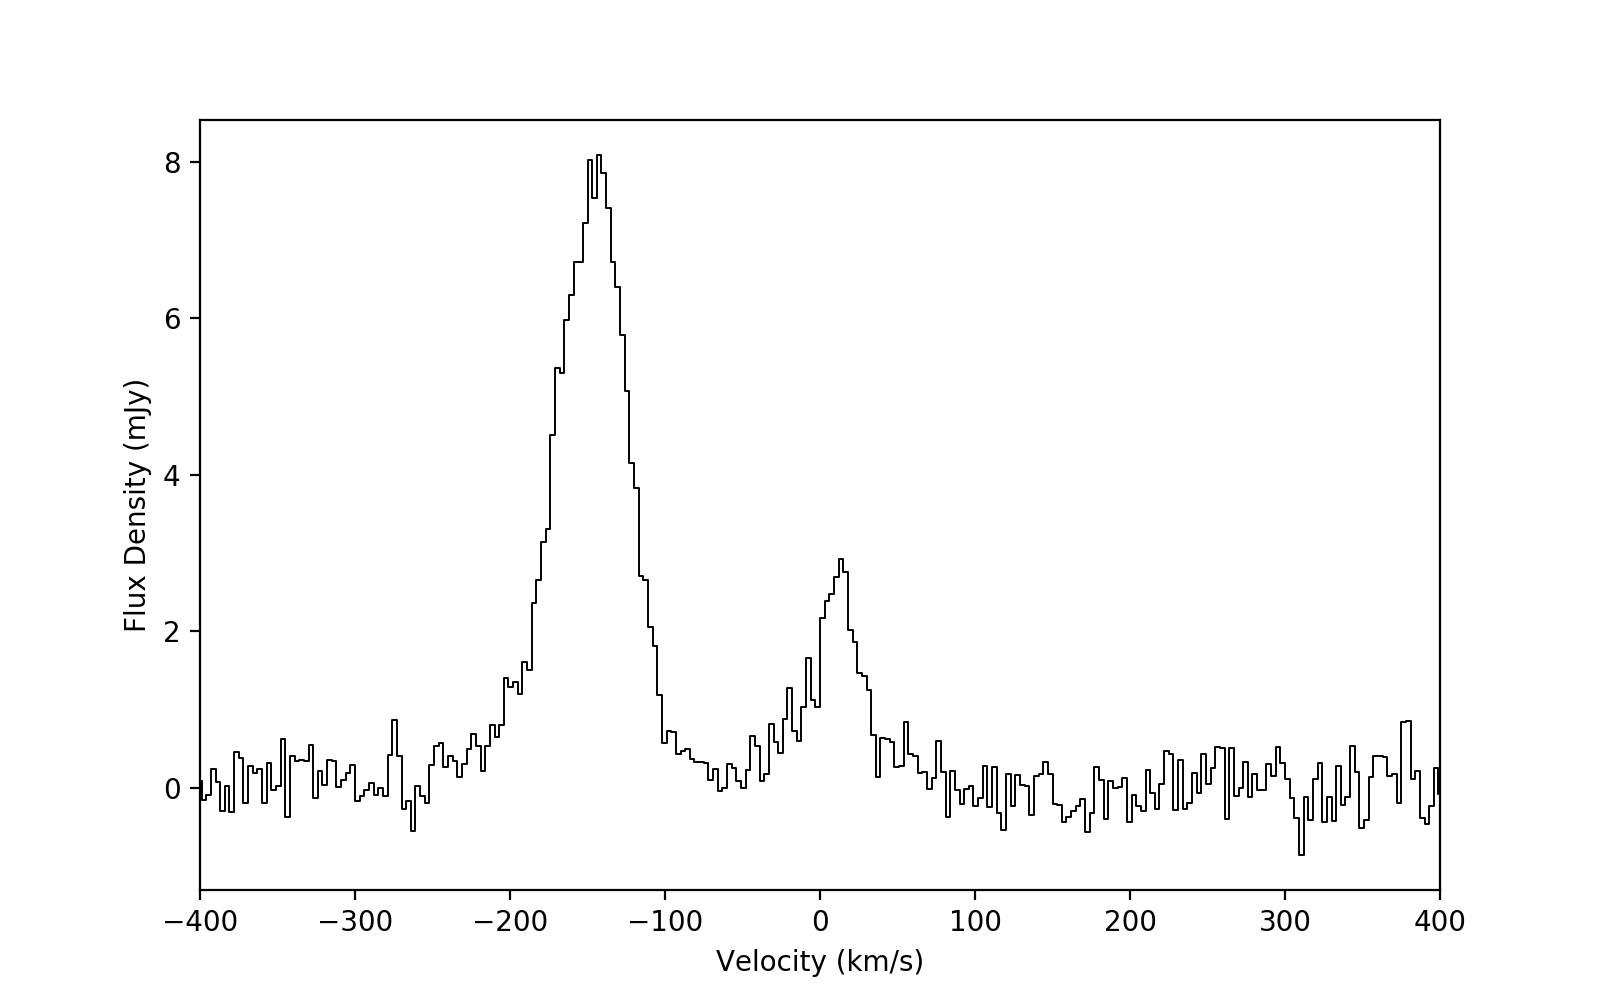

In [97]:
f,ax = plt.subplots(figsize=(8,5))

ax.step(spectra_new[0],spectra_new[1],'k', linewidth=0.7)
ax.set_xlim(-400,400)
ax.set_xlabel('Velocity (km/s)')
ax.set_ylabel('Flux Density (mJy)')

In [106]:
def multigauss(x, *params):
    N = len(params)
    I0 = [params[i] for i in range(0,N,3)]
    v0 = [params[i] for i in range(1,N,3)]
    w  = [params[i] for i in range(2,N,3)]
    
    y=0
    for i in range(len(I0)):
        y += I0[i]*np.exp(-4*np.log(2)*(x-v0[i])**2/w[i]**2)  
        
    return y

In [107]:
p0 = [8,-150,40,2.5,10,20]

# now we can try to fit the data
popt, pcov = curve_fit(multigauss, spectra_new[0], spectra_new[1], p0=p0)

<IPython.core.display.Javascript object>


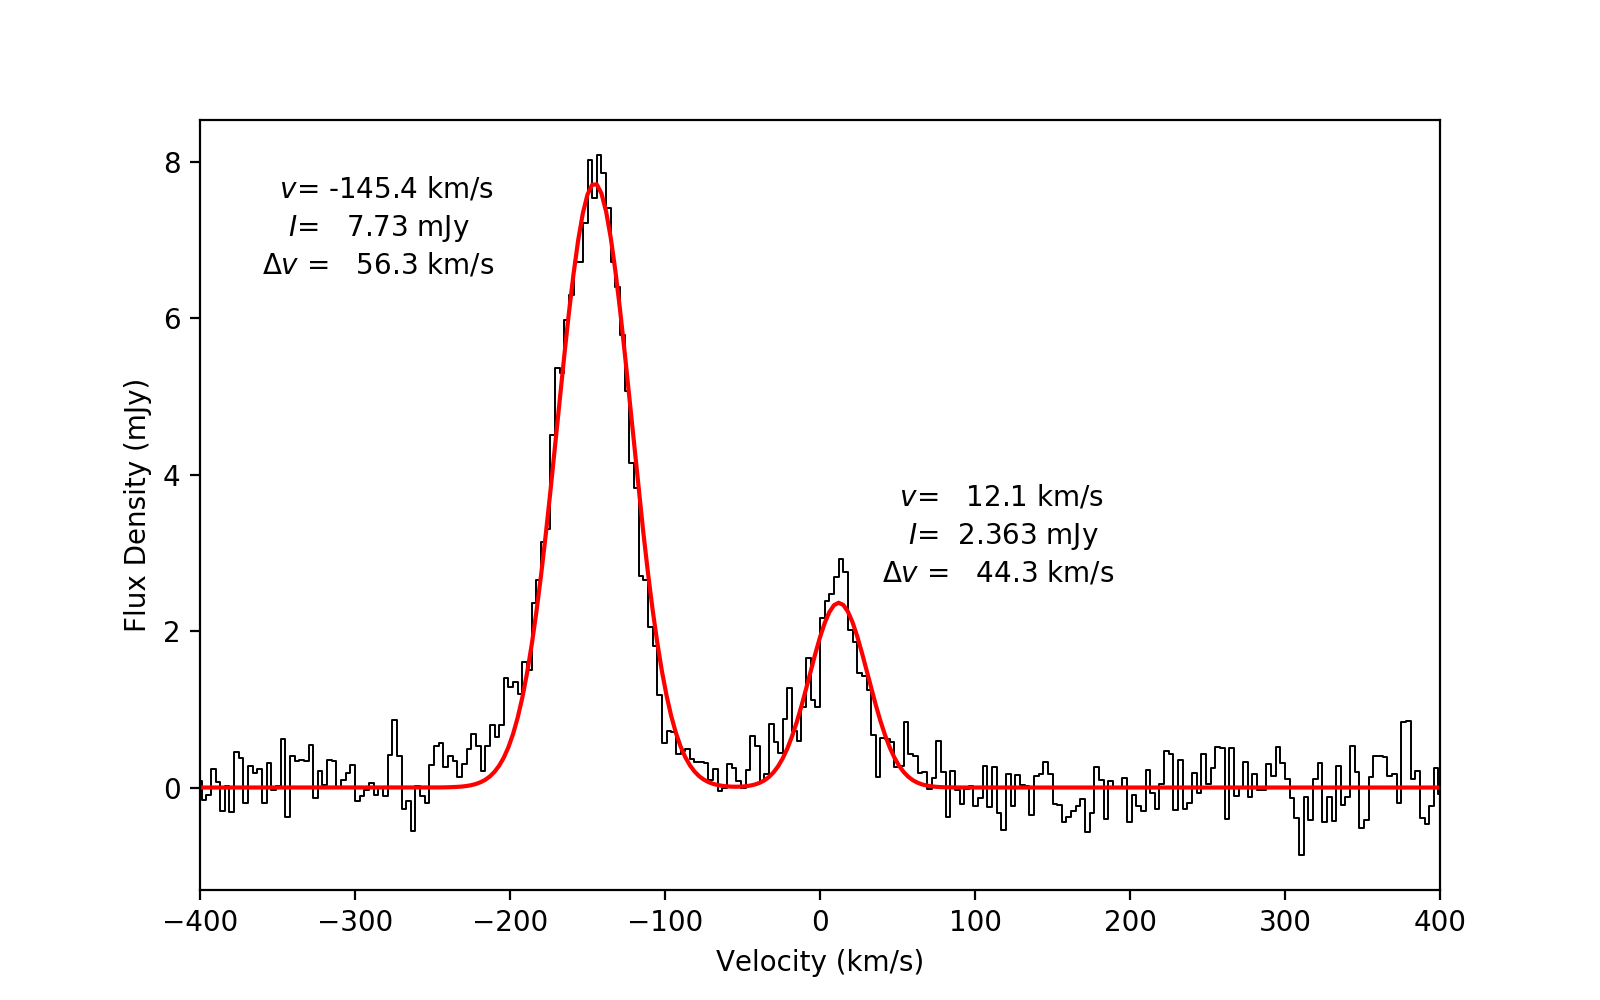

In [108]:
f,ax = plt.subplots(figsize=(8,5))

ax.step(spectra_new[0],spectra_new[1],'k', linewidth=0.7)
ax.set_xlim(-400,400)
ax.set_xlabel('Velocity (km/s)')
ax.set_ylabel('Flux Density (mJy)')
ax.plot(spectra_new[0], multigauss(spectra_new[0], *popt), 'r')

ax.text(0.05,0.9,f'  $v$={popt[1]:7.4} km/s',transform=ax.transAxes)
ax.text(0.05,0.85,f'   $I$={popt[0]:7.3} mJy',transform=ax.transAxes)
ax.text(0.05,0.8,f'$\Delta v$ ={popt[2]:7.3} km/s',transform=ax.transAxes)

ax.text(.55,0.5,f'  $v$={popt[4]:7.4} km/s',transform=ax.transAxes)
ax.text(.55,0.45,f'   $I$={popt[3]:7.4} mJy',transform=ax.transAxes)
ax.text(.55,0.4,f'$\Delta v$ ={popt[5]:7.3} km/s',transform=ax.transAxes)

***
<a id='sectionB'></a>
## B. Using Data from Bubbles in the Milky Way

<img src="http://www.spitzer.caltech.edu/uploaded_files/images/0008/5977/sig12-002_Med.jpg" width = "800x">

Now we will look at “bubbles” in the Milky Way that have been classified thanks to citizen scientists as part of the Zooniverse project. 

What are these “bubbles”? 

“They are regions around young massive stars that are so bright that their light has caused a shock wave to affect the cloud around them and blown a bubble which we can see in infrared light. The dark interior is where the shock has already passed by and the bright red/pink ring around it is where the shock is currently impacting the gas cloud. Most of the circular features (bubbles) in these images are produced by hot young stars, as winds and radiation from these young stars sweep up the surrounding gas and dust from which they formed (like a snowplow that compresses the snow in its path.) Sometimes, the swept-up material becomes dense enough for gravity to pull it together to form new stars.” -- Zooniverse Milky Way

So what are you going to do?....

Let's visualize where the <a href="https://www.milkywayproject.org/">Zooniverse MilkyWay Project</a> Bubbles are located in our <a href="http://i.space.com/images/i/000/001/163/i02/050816_milky_way_02.jpg?1292263533">Milky Way Galaxy</a>. 

In your data folder is <a href="data/MWbubbles.fits">MWbubbles.fits</a>. This file has the classification results for all the large bubbles discovered through the MilkyWay Project. 

For each of the 3744 bubbles, MWbubbles.fits provides the Galactic longitude and latitude (see figure below), radius, thickness, eccentricity, position angle, hit rate, dispersion on position, and hierarchy flag. 

We'll focus on visualizing the Bubbles' Galactic latitude and longitude.

#### What is Galactic Latitude and Longitude?
* On the left is an image showing Earth-based longitude and latitude. 
* On the right is Galactic longitude and latitude. Same idea, but for our whole Galaxy. 

<img style="float: left" src="http://upload.wikimedia.org/wikipedia/commons/6/62/Latitude_and_Longitude_of_the_Earth.svg" width = 440> <img style="float: right" src="http://burro.case.edu/Academics/Astr306/Coords/galactic.jpg" width = 440>

### 1. Read in your Data

In [20]:
# Now we will use astropy to read our data.
import astropy.io.fits as fits

# Read in *.fits data file
Bubbles = fits.open('data/MWbubbles.fits')

# Assign Bubbles_data to contain all the data in this table
Bubbles_data = Bubbles[1].data

# Print the names of each column in this table
print(Bubbles[1].columns.names)

['MWP', 'ONames', 'GLON', 'GLAT', 'iXdiam', 'iYdiam', 'oXdiam', 'Reff', 'Thick', 'Ecc', 'PA', 'Hit', 'Disp', 'Flag']


#### Here's a brief description of what each column name refers to:

* MWP = Milky Way Project Catalog ID
* ONames = Other names given each object in the catalog
* GLON = Galactic Longitude
* GLAT = Galactic Latitude
* iXdiam = Inner X Diameter
* iYdiam = Inner Y Diameter
* oXdiam = Outer X Diamter
* Reff = Effective Radius
* Thick = Effective Thickness
* Ecc = Eccentricity
* PA = Ellipse Position Angle
* Hit = Hit Rate (indicates the fraction of people who identified this bubble)
* Disp = Dispersion on the position
* Flag = Hierarchy flags (indicates whether the bubble is associated with other bubbles)

<a href="https://vault.it.northwestern.edu/let412/Adler/PythonZoo/articles/MWproject_Simpson_2012_2442.full.pdf">Science research article with additional information on each of these.</a>

You can explore what type of data is in each of these columns by changing the appropiate line below. 

In [21]:
# Print the first three and last three of the values in this particular column of the data table
print(Bubbles_data['ONames'])

# The reason 'print' doesn't print all 3744 values to your screen is because that would be annoying.
# Instead 'print' just gives a snapshot (through the first 3 and last 3 values)

['N22' 'S128' 'S137' ..., 'CS10' '' '']


### 2. Now let's make a scatter plot of the Bubble's longitude vs latitude

<IPython.core.display.Javascript object>


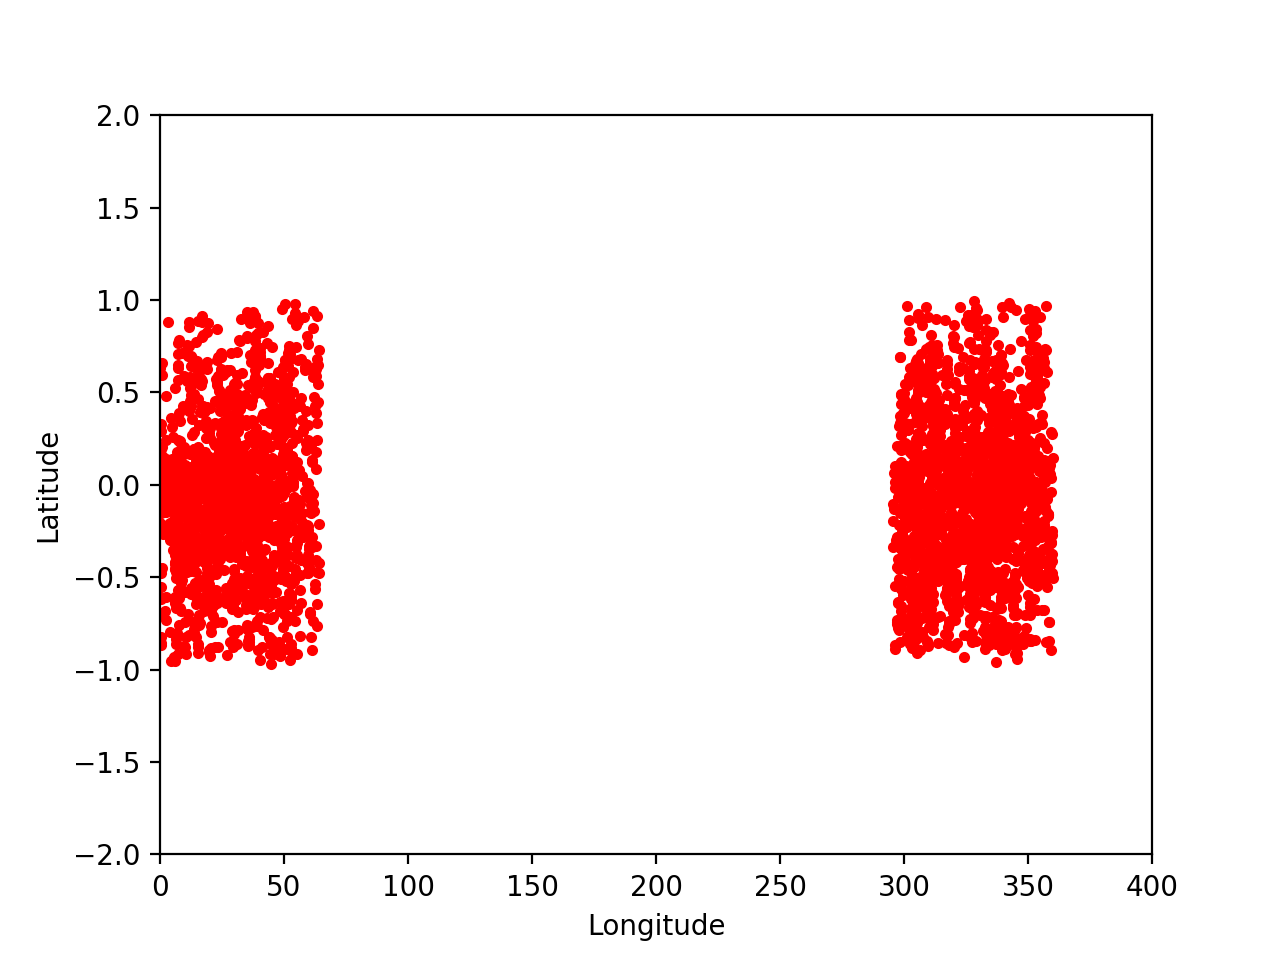

In [23]:
# Fill in the dashes to create arrays for longitude and latitude
Longitude = Bubbles_data['GLON']
Latitude = Bubbles_data['GLAT']
errorVal = 0.001

# Plot the data 
f,ax = plt.subplots()
ax.errorbar(Longitude, Latitude, yerr = errorVal, fmt='ro', markersize=3)

# Replace x1,x2,y1,y2 to set the axes range to be from 0 to 400 for the x-axis 
# and -2 to 2 for the y-axis
ax.set_xlim(0,400)
ax.set_ylim(-2,2)

# Label the plot
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

#### What?! 
Yes, your plot is missing everything in the middle.  Why does the Longitude vs. Latitude plot look so Funny? 

The image below is the area the MilkyWay Project looked at in the disk of our galaxy. 
* Do you notice how Longitude = 0 is at the Galactic Center? 
* Do you notice how the numbers increase to the left (0->60) and decrease to the right (360->300)? 

<img src="http://faculty.wcas.northwestern.edu/aaron-geller/myimages/ssc2014-02a1_ExLrg-v2.jpg" width=1000>

The image below is an artist's representation of the same thing. 
* Looking from our Sun straight towards the Galactic Center means looking at Longitude = 0. 
* Looking to the left means looking from 0->60 degrees and looking to the right means looking from 360->300 degrees.

<img src="http://faculty.wcas.northwestern.edu/aaron-geller/myimages/050816_milky_way_02.jpg" width = "400x" >

### 3. Let's fix our Visualization of the Bubbles' Galactic Latitude and Longitude

To fix your plot of Latitude versus Longitude, let's flip all the Longitude > 180 values so our longitude values decrease smoothly from left to right on our x-axis. <br>

Let's use numpy's where function again.

In [25]:
#Create a new array that's the same as the original Longitude array
import copy   #import useful library to make a copy of an array
Longitude_new = copy.copy(Longitude)

#Use the 'where' function to identify all the Longitude values > 180
toShift = np.where(Longitude>180)[0]

#Subtract 360 from all chosen "toShift" Longitude values
Longitude_shifted = Longitude[toShift]-360

#Replace the old "toShift" Longitude values with these new Longitude values
Longitude_new[toShift] = Longitude_shifted

Now let's plot these new Bubble Longitude vs Latitude values.

<IPython.core.display.Javascript object>


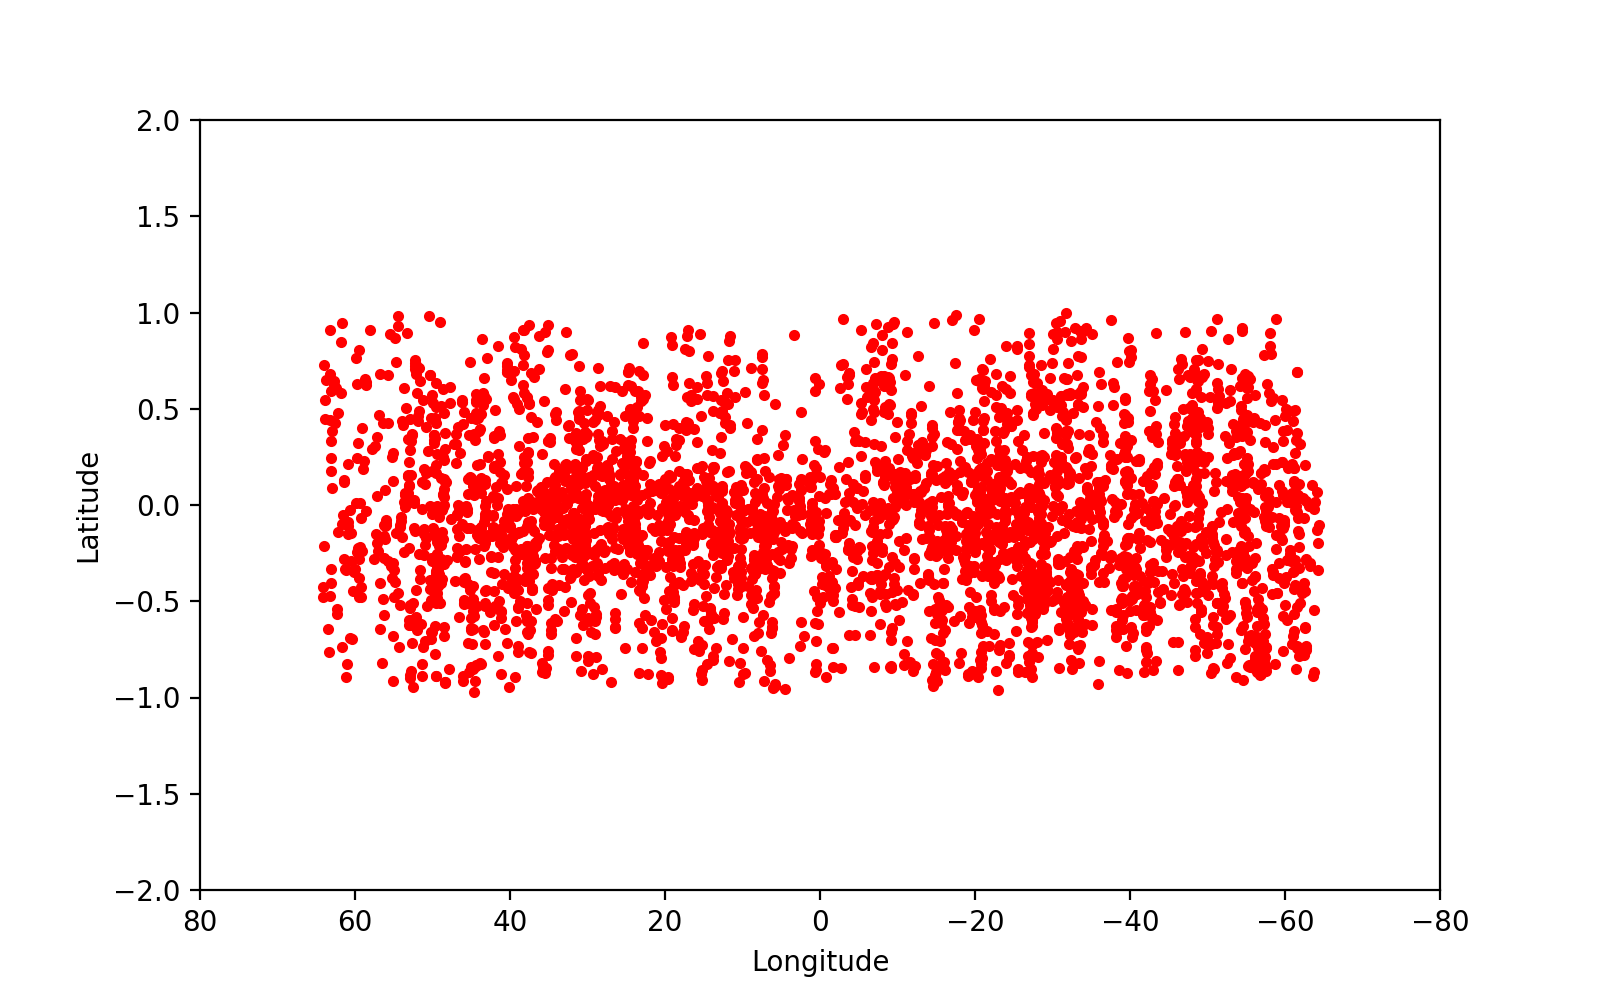

In [26]:
#Plot Longitude_new versus Latitude
f,ax = plt.subplots(figsize=(8,5))
ax.plot(Longitude_new, Latitude, 'ro', markersize=3)

#Switch the order of the X-axis range, so it goes from 80 to -80.
#Keep the y-axis range as -2 to 2.
ax.set_xlim(80,-80)
ax.set_ylim(-2,2)

#Label plot
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

### 4. Fit a line to the data.

fit coefficients:
 Slope = 0.00027130573521504174, Intercept = -0.06070230987630175


<IPython.core.display.Javascript object>


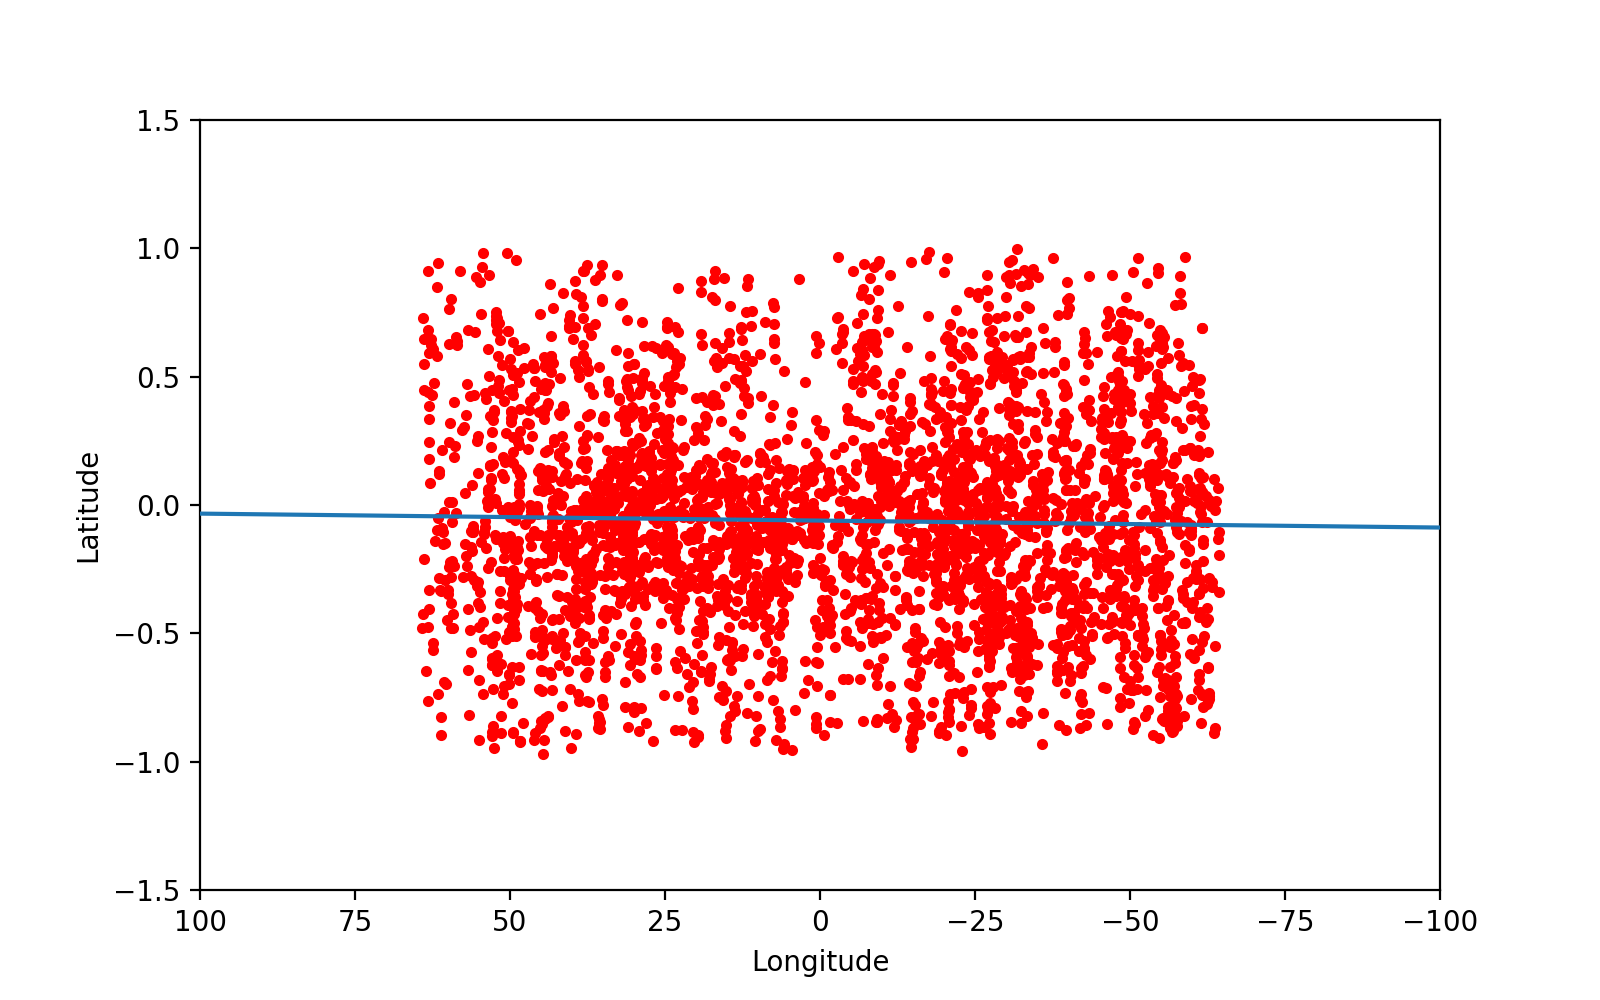

In [27]:
# Define the function (i.e., the model) you'll fit to your data
# Here we use a linear fit again (but you have to make the function!)
# Fill in the dashes with the correct input
def fitFunc(x,m,b):
    return m*x+b

fitCoeff, fitCovar = curve_fit(fitFunc, Longitude_new, Latitude)
print(f'fit coefficients:\n Slope = {fitCoeff[0]}, Intercept = {fitCoeff[1]}')

# Plot your data
f,ax = plt.subplots(figsize=(8,5))
#Fill in the dashes with the correct input
ax.errorbar(Longitude_new, Latitude, yerr = errorVal, fmt='ro', markersize=3)
ax.set_xlim(100,-100)
ax.set_ylim(-1.5,1.5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Define the x-values for the best-fit line
bestfit_x = np.linspace(-100,100,200) #an array from -100 to 100, with 200 linearly spaced points

# Define the y-values for the best-fit line, using the fitFunc function you defined above
# Fill in the dashes with the correct input, based on what you learned from 'play with plots'
bestfit_y = fitFunc(bestfit_x, fitCoeff[0], fitCoeff[1])

# Overplot the best-fit line in blue (default color)
# Include a 'zorder=5' argument to make sure the line is plotted over the data.
ax.plot(bestfit_x, bestfit_y,zorder=5)

 #### Question: Does your result make sense?
 * Why might the best-fit go through Latitude = 0?
 * What does Latitude = 0 coincide with in our galaxy?
 * Let's explore the Latitude bubble distribution further...
 
### 5.  Histogram 
 
Histograms are the natural choice to visualize the number of occurences with respect to a variable (in this case, latitude).  We will use matplotlib's `hist` function to plot this.

<IPython.core.display.Javascript object>


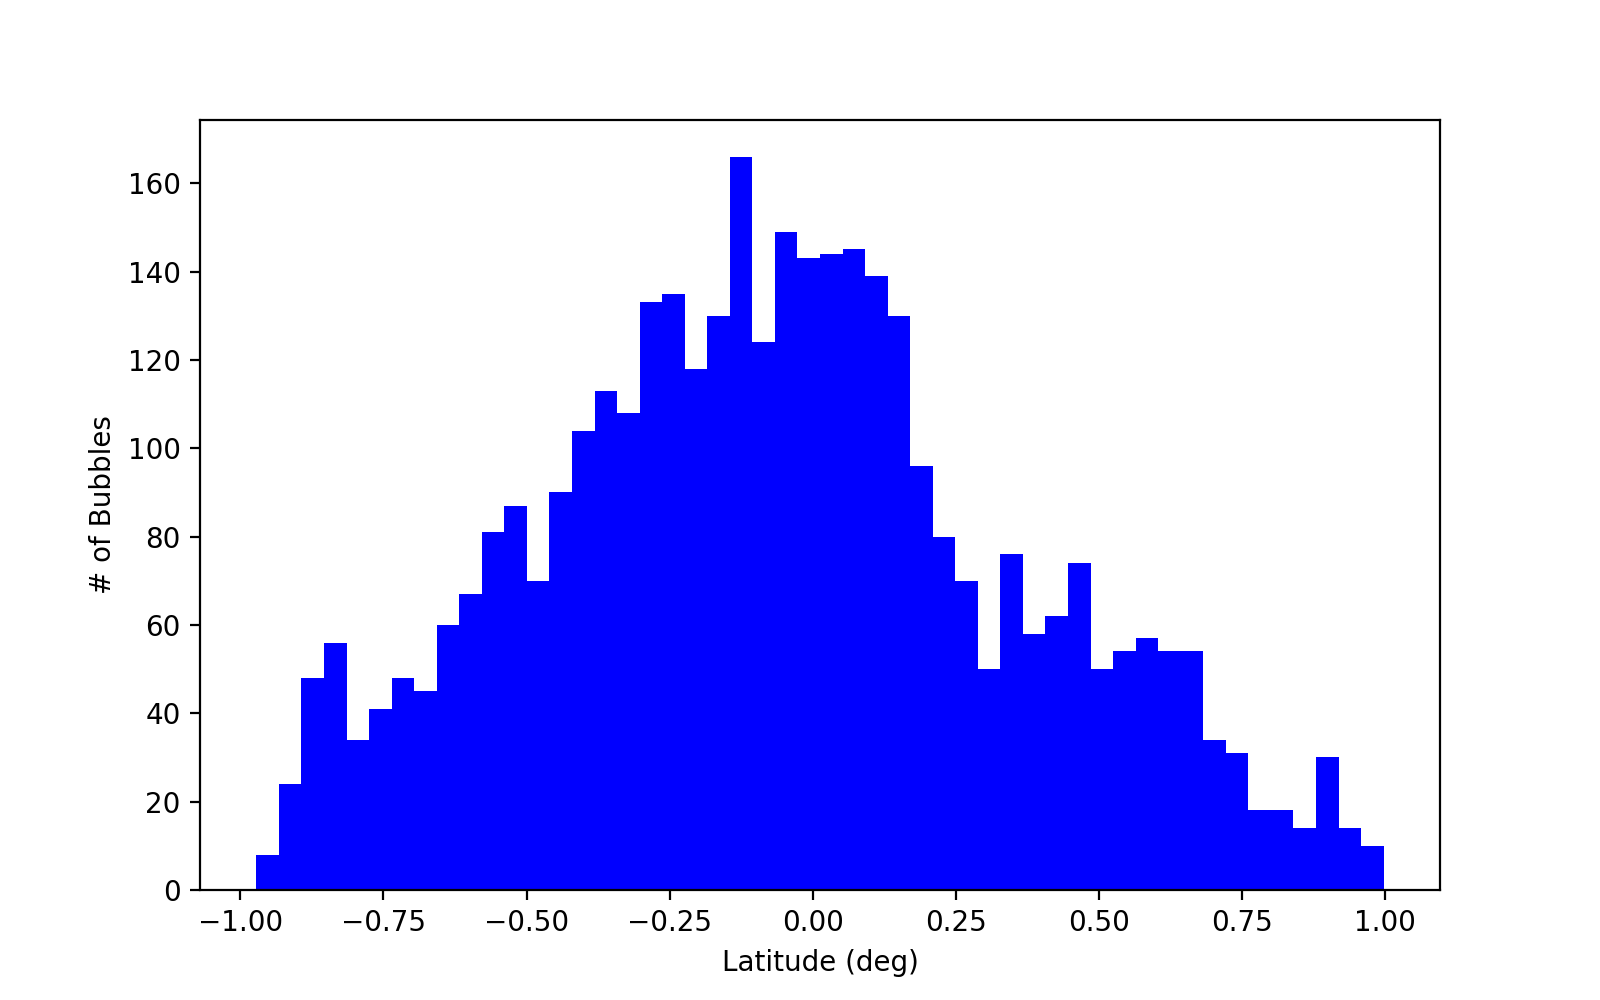

In [28]:
# in addition to plotting the histogram,
# the hist function also returns a tuple of useful information that we will need.
# thus we will make sure we grab the tuple
f,ax = plt.subplots(figsize=(8,5))
n, bins, patches = ax.hist(Latitude, bins=50, facecolor='blue')

ax.set_xlabel('Latitude (deg)')
ax.set_ylabel('# of Bubbles')

As we expected and saw in our previous plot/fit, more bubbles appear near a latitude of 0 degrees.  In fact, the distribution almost appears Gaussian...

Lets attempt to fit a Gaussian to this distribution similar to what we did with the recombination line spectrum.  We will use the tuple returned by `hist` to fit and plot:
    - n: this is the number of occurrences in each bin.
    - bins: this is the value of the bin edges.
    
Notice that `len(bins) = len(n) + 1`, this means we can't plot these together without some modification.  The `bins` array is longer because if each value is the left edge of a bin then there is an additional element for the last right edge. 

Instead, we will create a new array that is the midpoint of each neighboring bin.

<IPython.core.display.Javascript object>


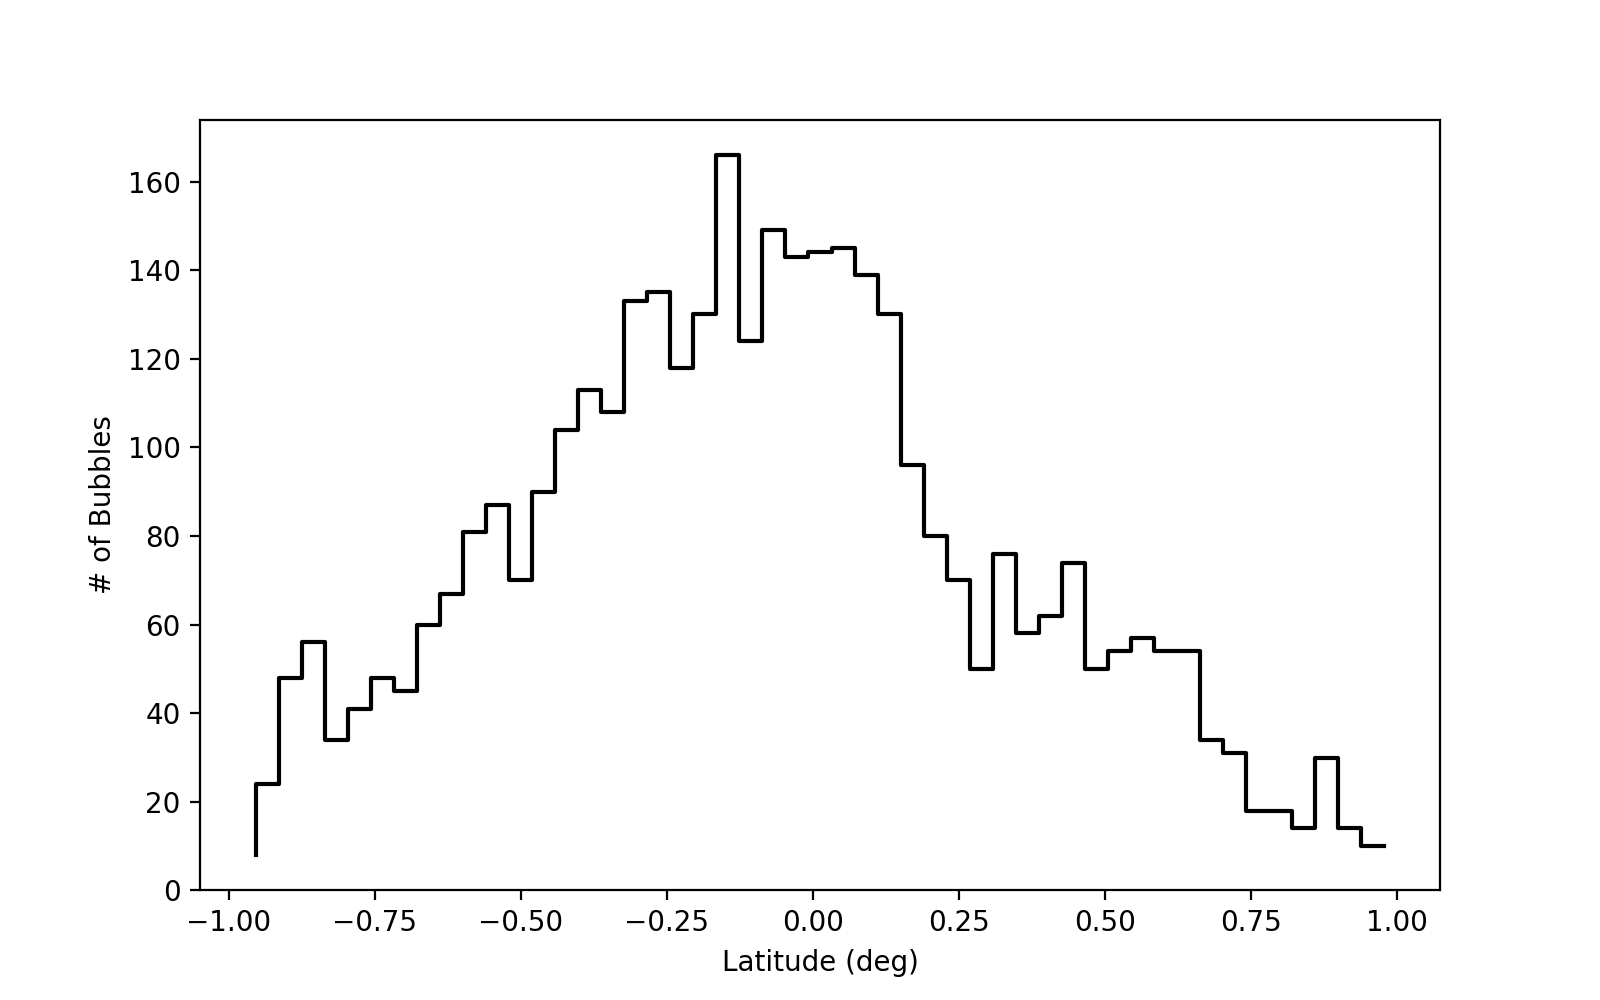

In [29]:
# the first bin is the average of the first two bins
firstBin = (bins[1] + bins[0])/2
# similarily, the last bin is the average of the last two bins
lastBin = (bins[len(bins)-1] + bins[len(bins)-2])/2
# the new (50 element) array is then
midBins = np.linspace(firstBin, lastBin, len(n))

# a quick plot to make sure our above modifications made sense
f,ax = plt.subplots(figsize=(8,5))
# it should look identical to the histogram
ax.step(midBins, n, 'k')
ax.set_xlabel('Latitude (deg)')
ax.set_ylabel('# of Bubbles')

In [ ]:
# Redefining the gaussian function
def gauss(x, *params):
    peak, vel, fwhm = params
    y = peak * np.exp(-4*np.log(2)*(x-vel)**2/fwhm**2)           
    return y

Now just as we fit the recombination line, you will want to supply an intial guess before utilizing `curve_fit`.

In [30]:
p0 = [140, 0, .75]

fitCoeffs, fitCov = curve_fit(gauss, midBins, n, p0=p0)

<IPython.core.display.Javascript object>


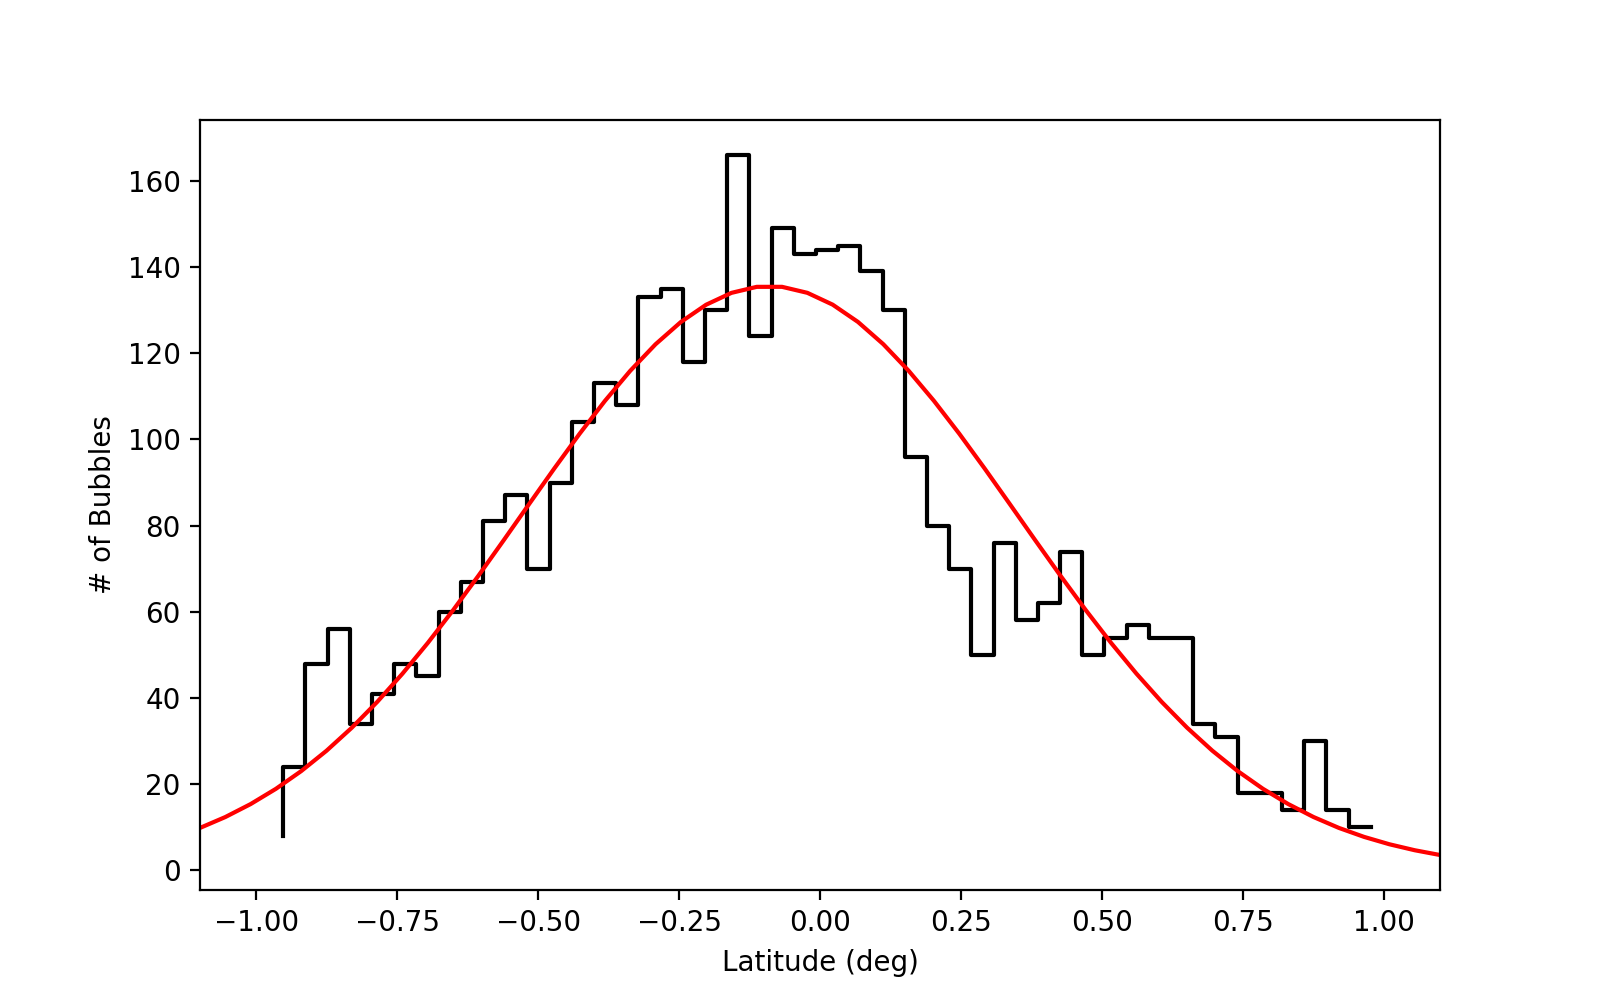

In [31]:
# another plot to make sure the fit makes sense
f,ax = plt.subplots(figsize=(8,5))
ax.step(midBins, n, 'k')

bestfit_x = np.linspace(-1.1,1.1)  # lets creat x-values from -1.1 to 1.1
ax.plot(bestfit_x, gauss(bestfit_x,*fitCoeffs), 'r')  
# set labels and x limits
ax.set_xlim(-1.1,1.1)
ax.set_xlabel('Latitude (deg)')
ax.set_ylabel('# of Bubbles')

In [32]:
# print out the results
peak = fitCoeffs[0]
vel = fitCoeffs[1]
fwhm = fitCoeffs[2]

peakErr = np.sqrt(fitCov[0][0])
velErr = np.sqrt(fitCov[1][1])
fwhmErr = np.sqrt(fitCov[2][2])

print(f'The largest count is  : {peak:5.5} +/-{peakErr:4.2} bubbles')
print(f'The center Latitude is: {vel:5.5} +/-{velErr:4.2} degrees')
print(f'The FWHM is           : {fwhm:5.5} +/-{fwhmErr:4.2} degrees')

The largest count is  : 135.59 +/- 4.1 bubbles
The center Latitude is: -0.089677 +/-0.015 degrees
The FWHM is           : 1.0392 +/-0.038 degrees


How does the center latitude found with the Gaussian `curve_fit` compare to the intercept found with the line `curve_fit` previously?  Are they within a standard deviation from each other?  Should they be the same?

### 6. Further Bubble Investigation

In [33]:
#Identify the arrays with the radius and thickness for all the bubbles
#Note: Reff = effective radius and Thick = effective thickness
radius = Bubbles_data['Reff']
thick = Bubbles_data['Thick']

#### What can we find out about the effective radius?

Use the `max`, `min`, and `mean` functions to print out the results for the data.

In [34]:
print(f'The maximum radius is: {max(radius)}')
print(f'The minimum radius is: {min(radius)}')
print(f'The mean radius is: {np.mean(radius)}')
print(f'The standard deviation of the radii is: {np.std(radius)}')

The maximum radius is: 11.720000267028809
The minimum radius is: 0.27000001072883606
The mean radius is: 1.3188835382461548
The standard deviation of the radii is: 1.2858152389526367


#### Identify the longitude/latitude values for the largest bubbles in the catalog

In [35]:
#Use the 'where' function to identify which bubbles have radii greater than 10.
bigLon = Longitude[np.where(radius > 10)]
bigLat = Latitude[np.where(radius > 10)]

#The 'len' command is short for 'length', telling you how many sources are in the big_lon array
print(f'# of bubbles with radius > 10: {len(bigLon)}')

#Print the Latitude/Longitude values for the bubbles of interest
#Use a 'for' loop to print the values as a pair for each bubble
for i,j in enumerate(bigLon):
    print(f'Longitude, Latitude: ({bigLon[i]:5.4}, {bigLat[i]:6.3})')

# of bubbles with radius > 10: 6
Longitude, Latitude: (18.91, -0.315)
Longitude, Latitude: (310.9,  0.562)
Longitude, Latitude: (348.8, -0.704)
Longitude, Latitude: (32.05, -0.071)
Longitude, Latitude: (51.99,  0.581)
Longitude, Latitude: (318.9,  0.057)


#### How does the bubble thickness relate to the bubble radius?

To finish up our Milky Way bubble investigation, make a plot of the bubble radius vs bubble thickness.  Do you see a trend?  If so, use `curve_fit` to find a best fit curve along with the uncertainties.

<IPython.core.display.Javascript object>


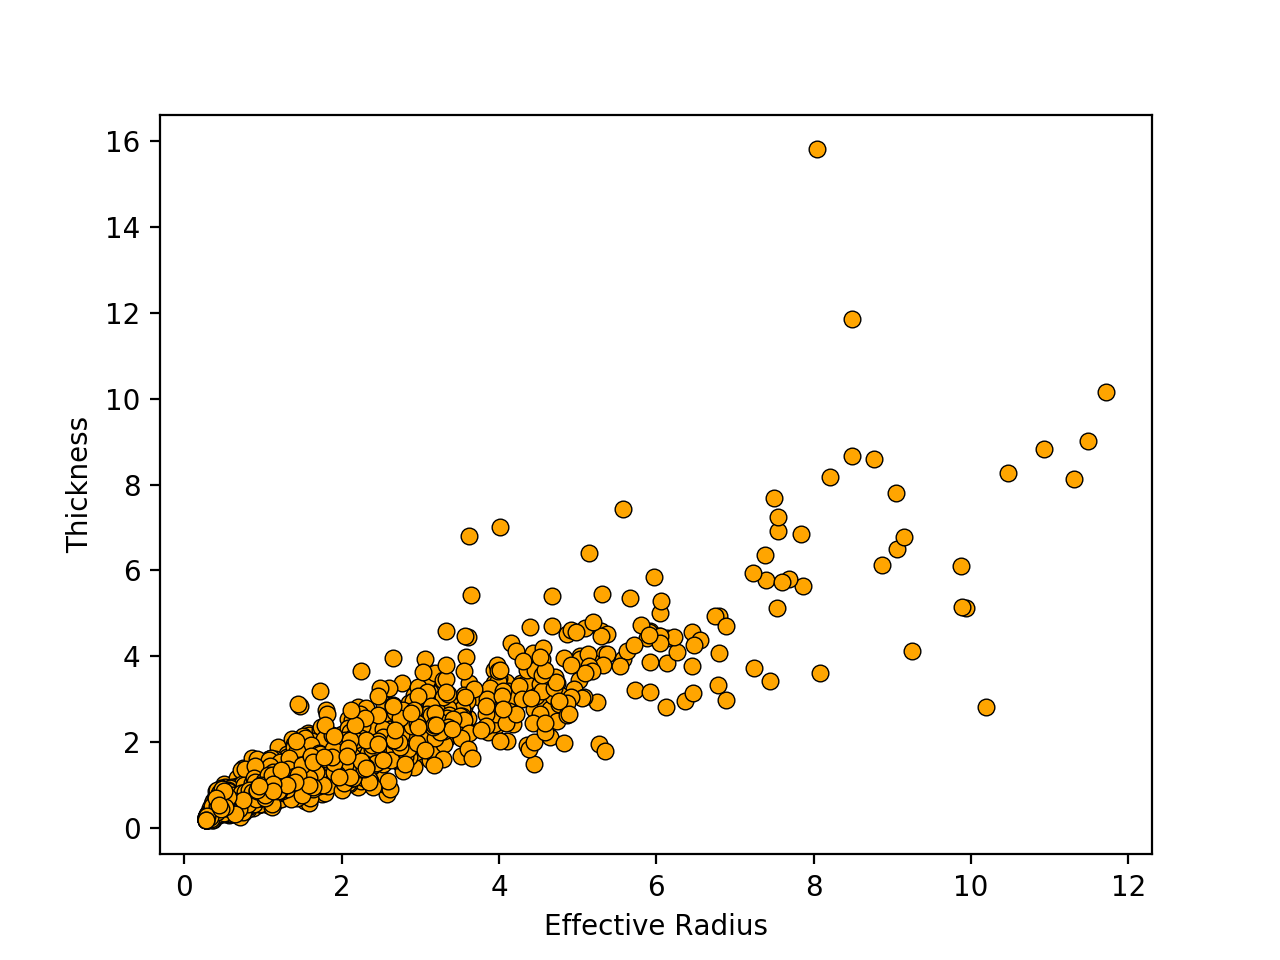

In [36]:
# making an initial plot of the effective radius vs the thickness to see the data
f,ax = plt.subplots()
ax.scatter(radius, thick, c='orange', linewidths=0.5, edgecolors='k')

# label the plot
ax.set_xlabel('Effective Radius')
ax.set_ylabel('Thickness')

In [39]:
# fitting a linear function
def fitFunc(x,m,b):
    return m*x+b

fitCoeffs, fitCov = curve_fit(fitFunc, radius, thick)

<IPython.core.display.Javascript object>


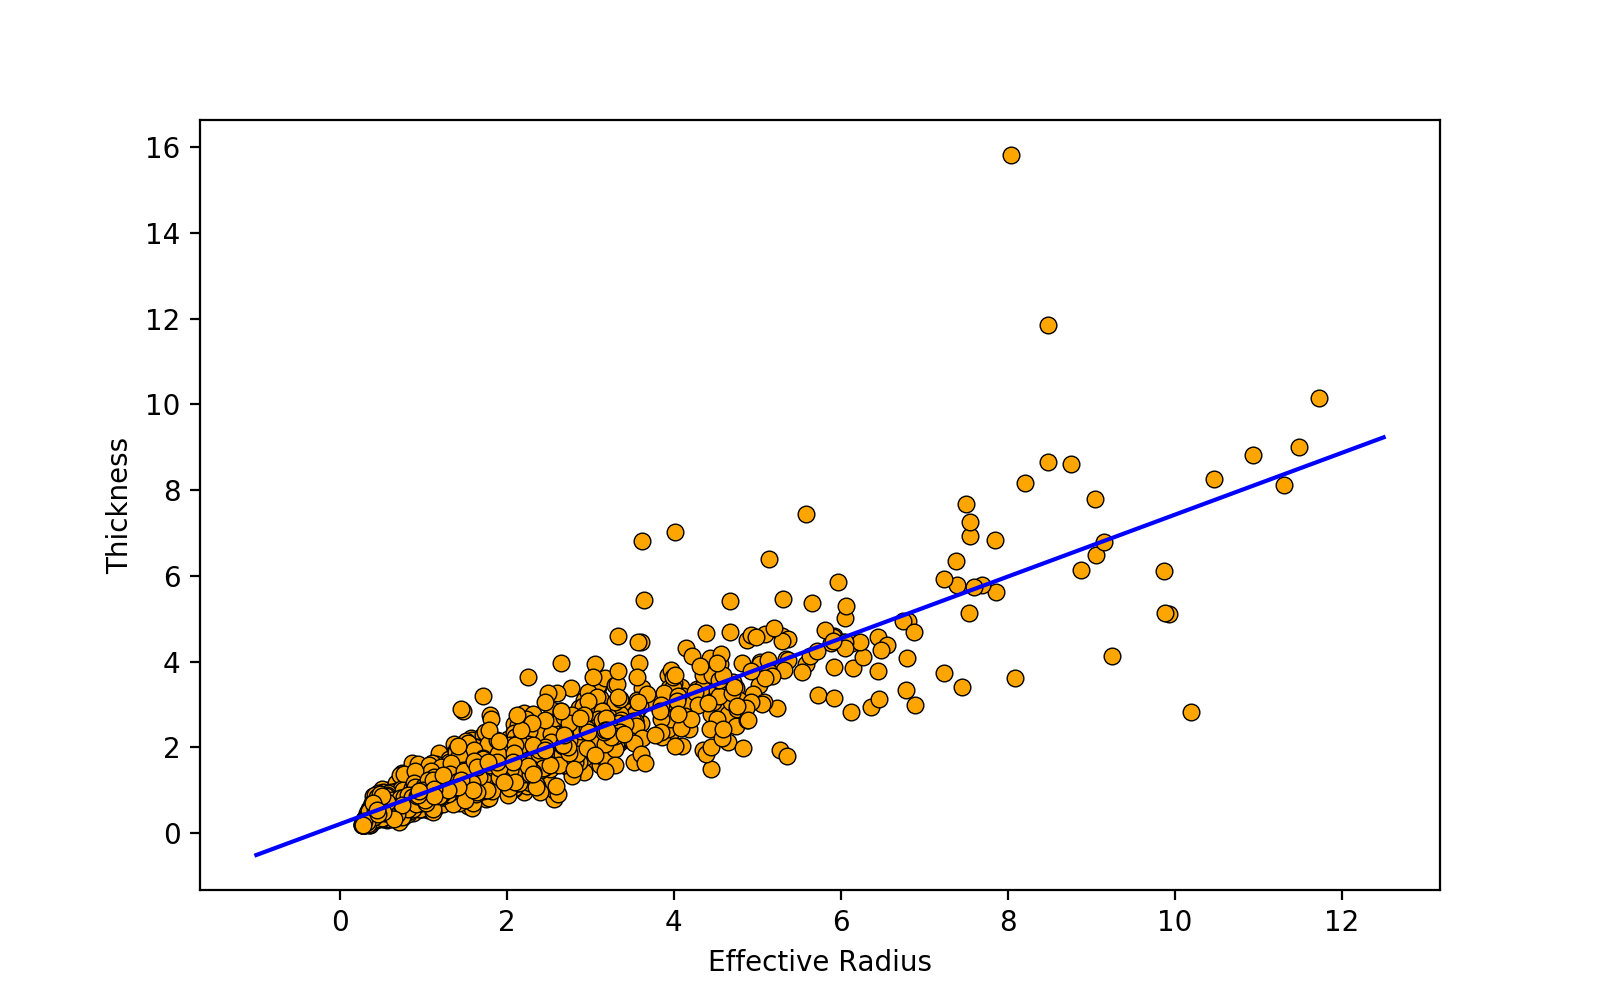

In [42]:
# plotting the results
f,ax = plt.subplots(figsize=(8,5))
ax.scatter(radius, thick, c='orange', linewidths=0.5, edgecolors='k')

bestfit_x = np.linspace(-1,12.5)  # get x-values from -1 to 12.5
ax.plot(bestfit_x, fitFunc(bestfit_x, fitCoeffs[0], fitCoeffs[1]), 'b')

# set xlim and labels
ax.set_xlabel('Effective Radius')
ax.set_ylabel('Thickness')

In [43]:
# Printing the results...
slope = fitCoeffs[0]
intercept = fitCoeffs[1]

slopeErr, interceptErr = np.sqrt(np.diag(fitCov))

print(f'The slope is    : {slope:5.5} +/-{slopeErr:4.2}')
print(f'The intercept is: {intercept:5.5} +/-{interceptErr:4.2}')

The slope is    : 0.72156 +/-0.0051
The intercept is: 0.21284 +/-0.0093


***
<a id='sectionC'></a>
## C. Zooniverse GalaxyZoo Data

### 1. Where are all the galaxies?

Let's see where in the universe our <a href="http://www.galaxyzoo.org"> GalaxyZoo</a> galaxies are located.

You will be using the data file <a href="data/GZ_class_mags.dat">GZ_class_mags.dat</a> which contains all of the classification results for the GalaxyZoo galaxies. Let's see what data is contained in this file. To read in this data file, we will use `ascii.read` command from `astroypy`.

In [44]:
# import needed libraries
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column
from astropy.io import ascii

# read in data table
Galaxies = ascii.read('data/GZ_class_mags.dat')
Galaxies.colnames

['ObjID',
 'NVOTE',
 'RA',
 'DEC',
 'P_EL',
 'P_CW',
 'P_ACW',
 'P_EDGE',
 'P_DK',
 'P_MG',
 'P_CS',
 'P_EL_DEBIASED',
 'P_CS_DEBIASED',
 'Spiral',
 'Elliptical',
 'Uncertain',
 'u_mag',
 'g_mag',
 'r_mag',
 'i_mag',
 'z_mag']

In order to determine the <i> location </i> of the galaxies, we will use the galactic latitude and longitude of the galaxies. These are called the <a href="http://astro.unl.edu/classaction/animations/coordsmotion/radecdemo.html">RA and DEC</a> values, and are located in columns three and four. Use these values to create a plot of the location of each galaxy in the sky.

In [45]:
# First, create two variables that point to the RA and DEC columns
RA = Galaxies['RA']
DEC = Galaxies['DEC']

Lets see where the Galaxies in our table are located by making a RA vs DEC plot.

<IPython.core.display.Javascript object>


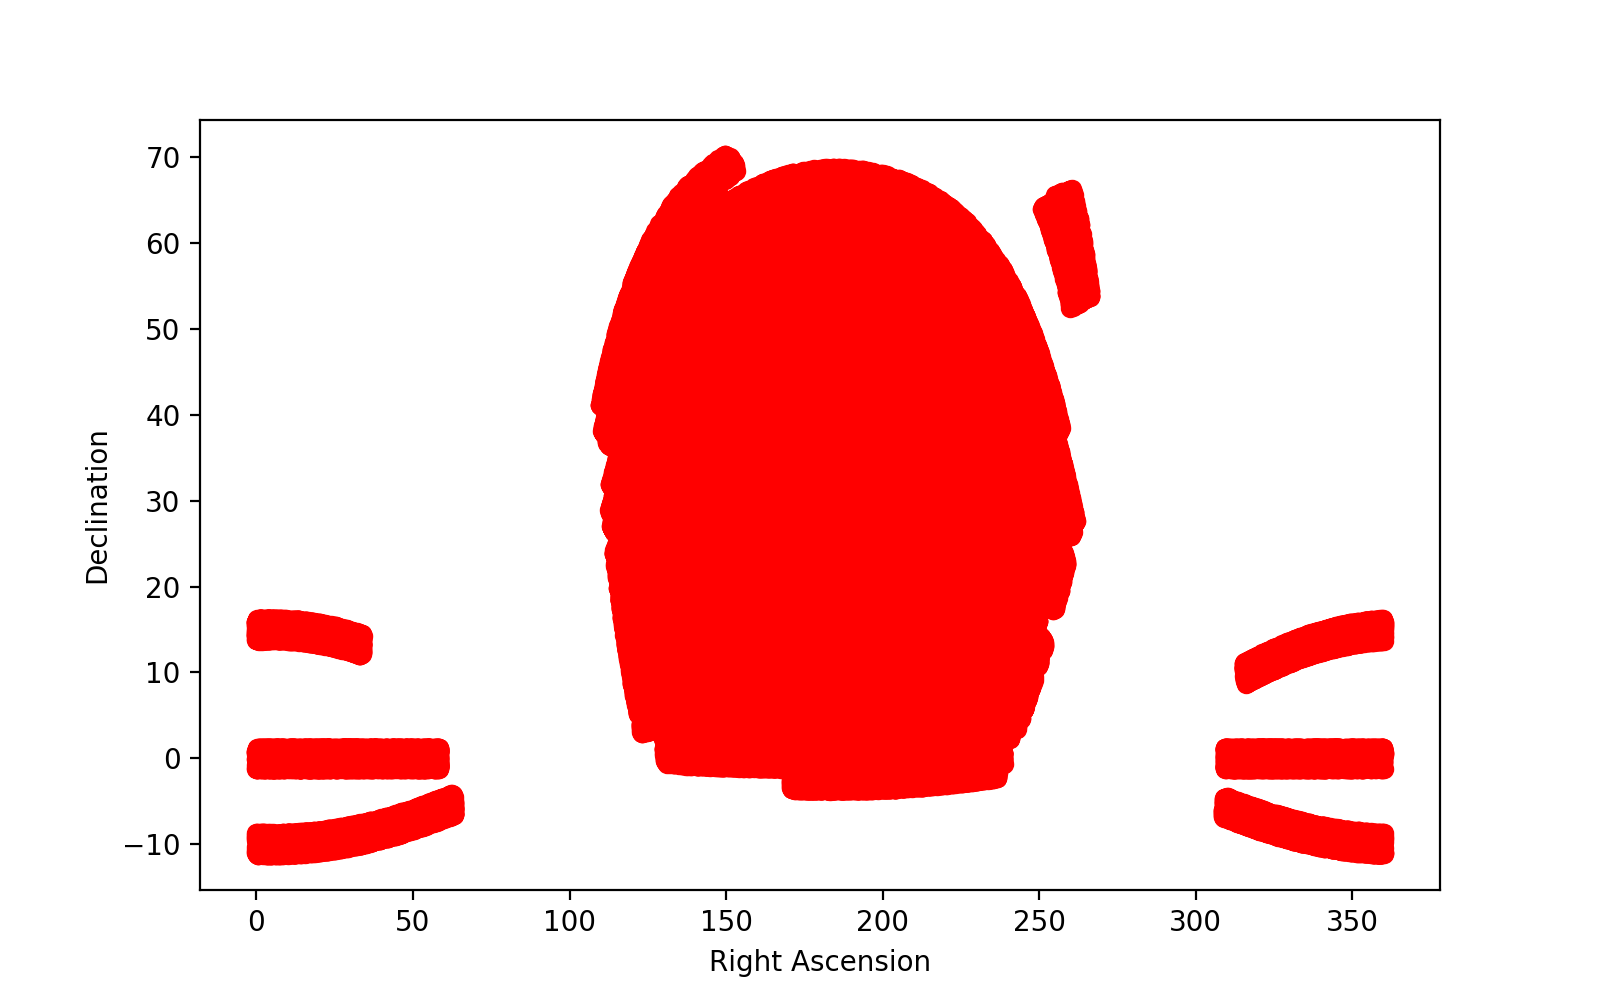

In [47]:
f,ax = plt.subplots(figsize=(8,5))
ax.scatter(RA,DEC, color='r')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

Your plot of RA vs Dec for all the Galaxy Zoo galaxies will look something like the image below (though doesn't need to be in this same projection). 

The yellow-green squiggle in the image is where the disk of our Milky Way galaxy lives. The disk of our Milky Way blocks our view of distant galaxies in that part of our sky. 

<img style= src="http://farm2.static.flickr.com/1055/4724975807_79f8722a8d_b.jpg" width = "500x">

### 2. What color are typical spiral galaxies?

Color is typically defined by using the difference of two bands.  In our case, we will subtract a galaxy's i-band (infrared) brightness from its g-band (green) brightness.  This will tell us how much bluer or redder the galaxy is. Smaller values of g-i mean the galaxy is bluer, larger values of g-i means that it's redder (remember small magnitudes means brighter).

In [48]:
# make a numpy array for the 'g_mag' and 'i_mag' columns each
gmag = np.array(Galaxies['g_mag'])
imag = np.array(Galaxies['i_mag'])

# now subtract the two array to get color
color = gmag - imag

# print the first few color values as a test
print(gmag[0:10])
print(imag[0:10])
print(color[0:10])

# print the min and max color
print()
print(f'MIN/MAX color: {min(color)}/{max(color)}')

[ 18.3143  18.0247  18.8566  17.9098  17.9106  18.7364  18.1929  18.4574
  15.4672  18.8939]
[ 16.7245  16.8384  17.2402  16.1118  16.6269  16.9182  16.8214  17.0128
  14.6428  17.2256]
[ 1.5898  1.1863  1.6164  1.798   1.2837  1.8182  1.3715  1.4446  0.8244
  1.6683]

MIN/MAX color: -10015.3137/10017.4529


Notice how the color values for first few galaxies are close to 1 but the min and max color are extremely low and high.

These very high/low values are because there are some sources for which the telescope was unable to get a good value for magnitude or brightness. In the table, the magnitudes for these sources have been set to -999, as a flag to indicate that they're bad values. 

Often when working with data, you'll need to be aware of 'bad' values and make sure you filter them out.

Lets use `np.where` to find the indices for these bad values.

In [52]:
# find the indices of the bad values
# make sure you consider both positive OR negative bad values
flag_ind = np.where((color < -99) | (color > 99))

# set the color values for these bad spots to NAN (not a finite #)
color[flag_ind] = np.nan

<IPython.core.display.Javascript object>


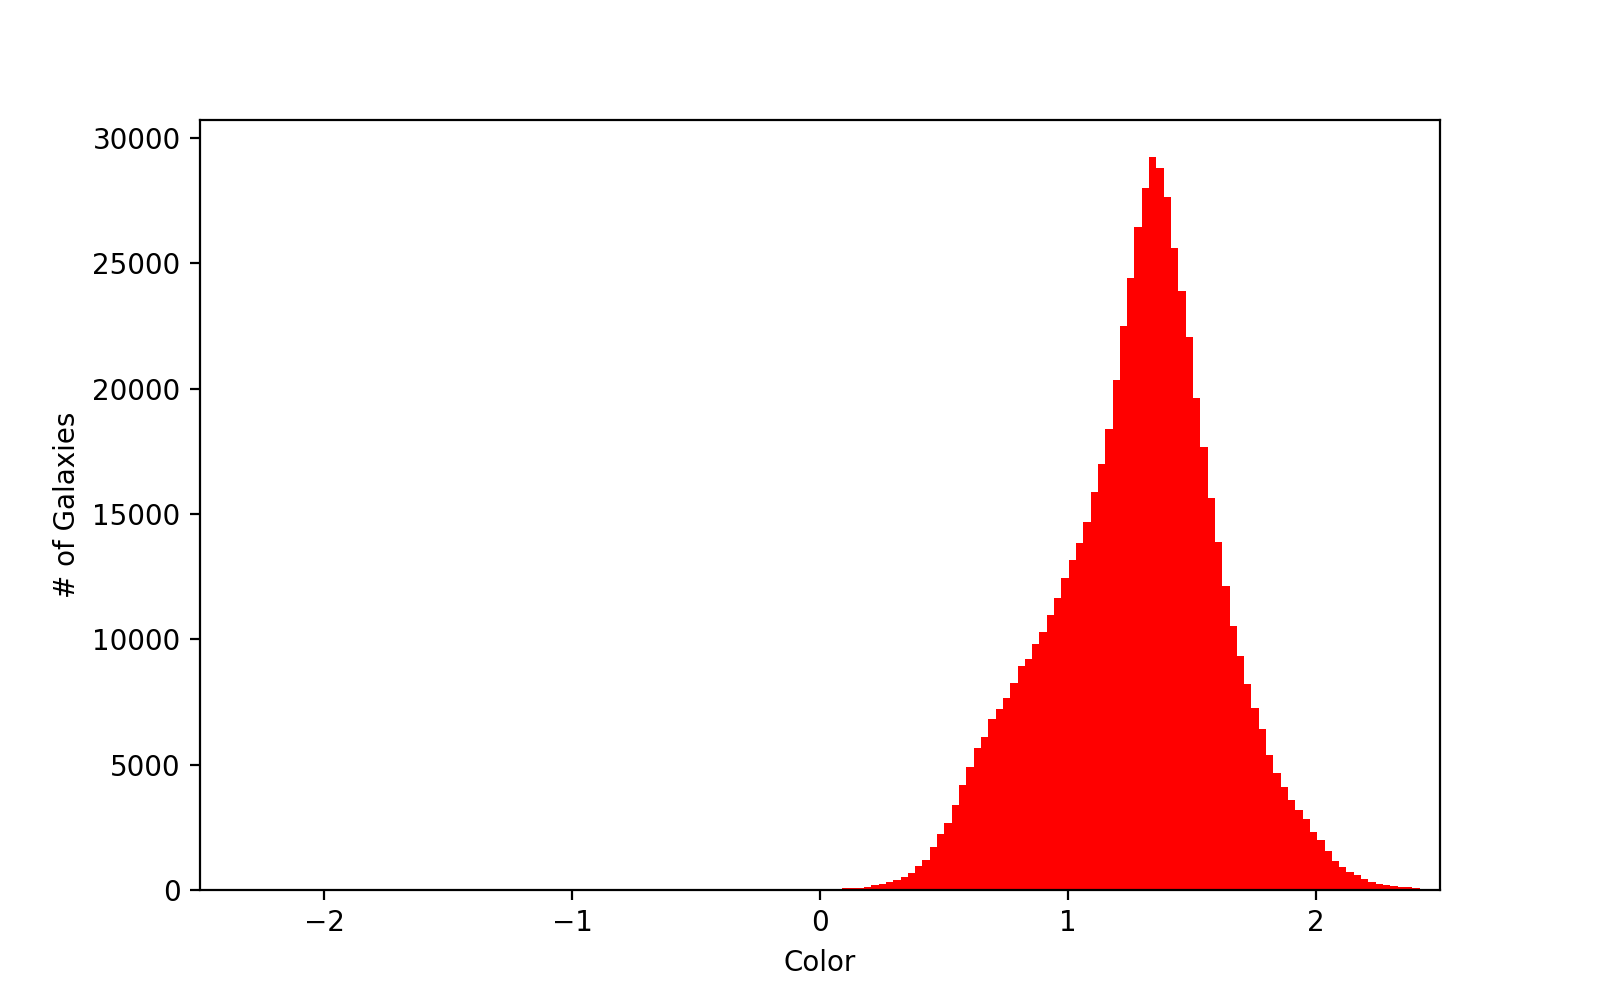

(-2.5, 2.5)

In [53]:
# plot a histogram for the galaxy color
f,ax = plt.subplots(figsize=(8,5))

# to avoid the flagged data use: color[np.isfinite(color)] 
ax.hist(color[np.isfinite(color)], bins=1000, facecolor='red')
ax.set_xlabel('Color')
ax.set_ylabel('# of Galaxies')
ax.set_xlim(-2.5,2.5)

### 3. Does the color depend on the type of galaxy?

Now, lets try to determine whether or not the color has any dependence on the galaxy being a spiral or elliptical type.

In [59]:
# we will use the np.where function again
# this time, to determine the indices for the two types of galaxies
spiral_ind = np.where(Galaxies['Spiral'] == 1)[0]
elliptical_ind = np.where(Galaxies['Elliptical'] == 1)[0]

# make a corresponding array that picks out these indices
spiral_color = color[spiral_ind]
elliptical_color = color[elliptical_ind]

<IPython.core.display.Javascript object>


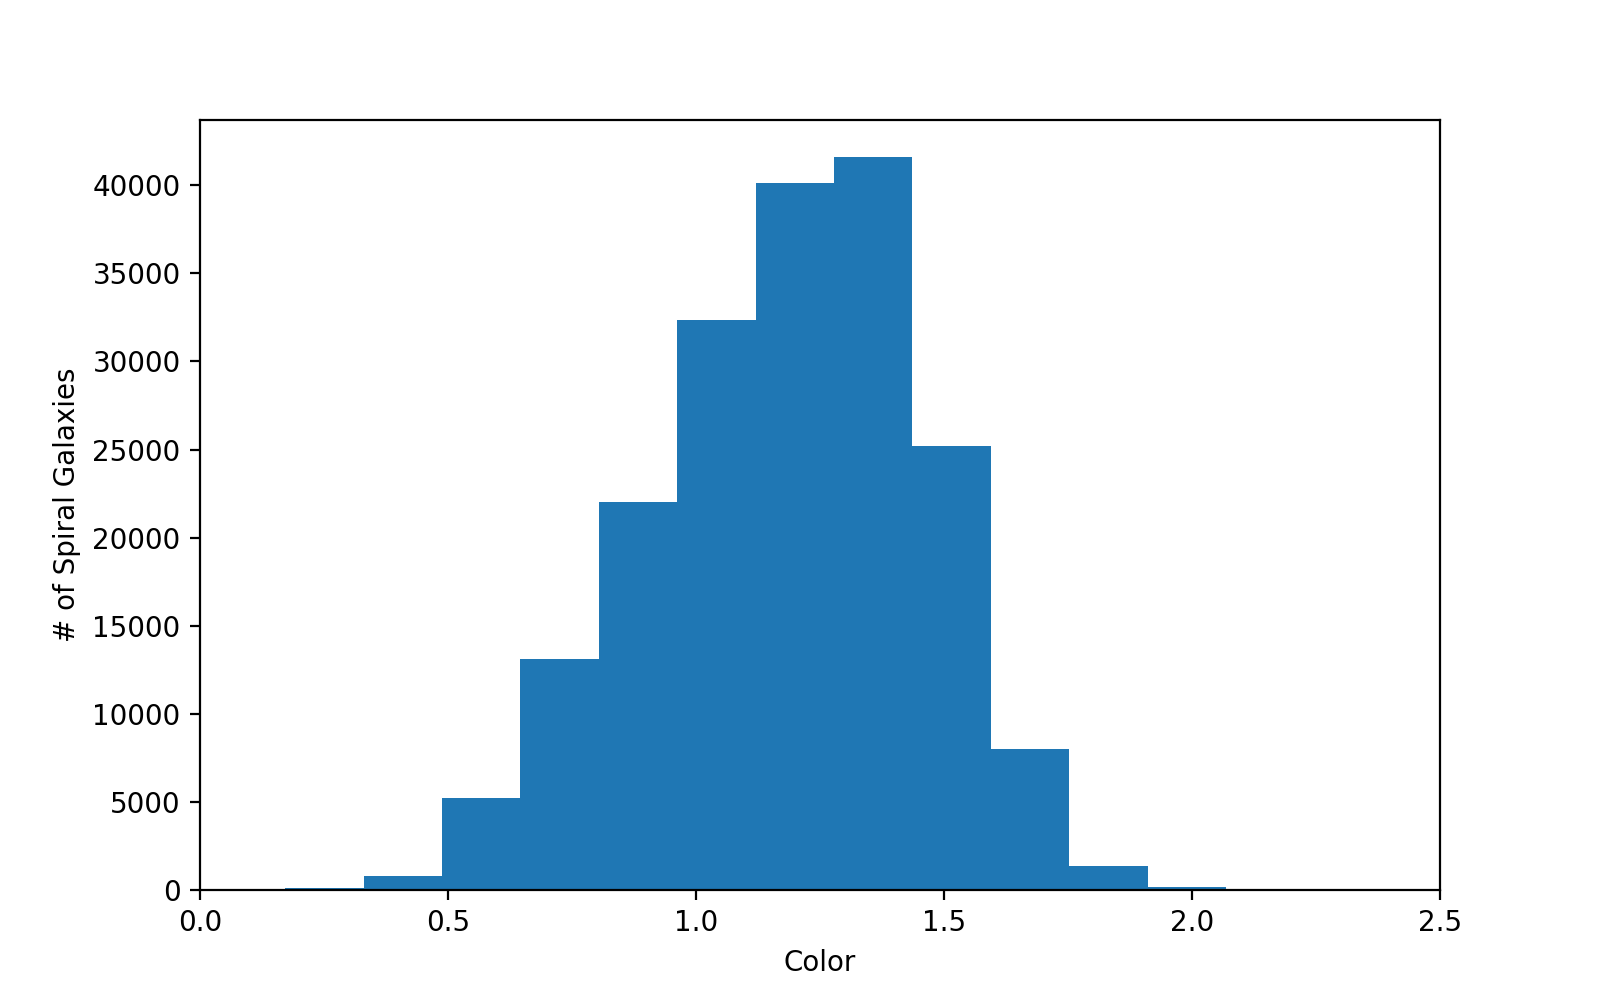

(0, 2.5)

In [60]:
# plot a histogram for the spiral galaxies
# lets make it blue
f,ax = plt.subplots(figsize=(8,5))
plt.hist(spiral_color[np.isfinite(spiral_color)], bins=100)
ax.set_xlabel('Color')
ax.set_ylabel('# of Spiral Galaxies')
ax.set_xlim(0,2.5)

<IPython.core.display.Javascript object>


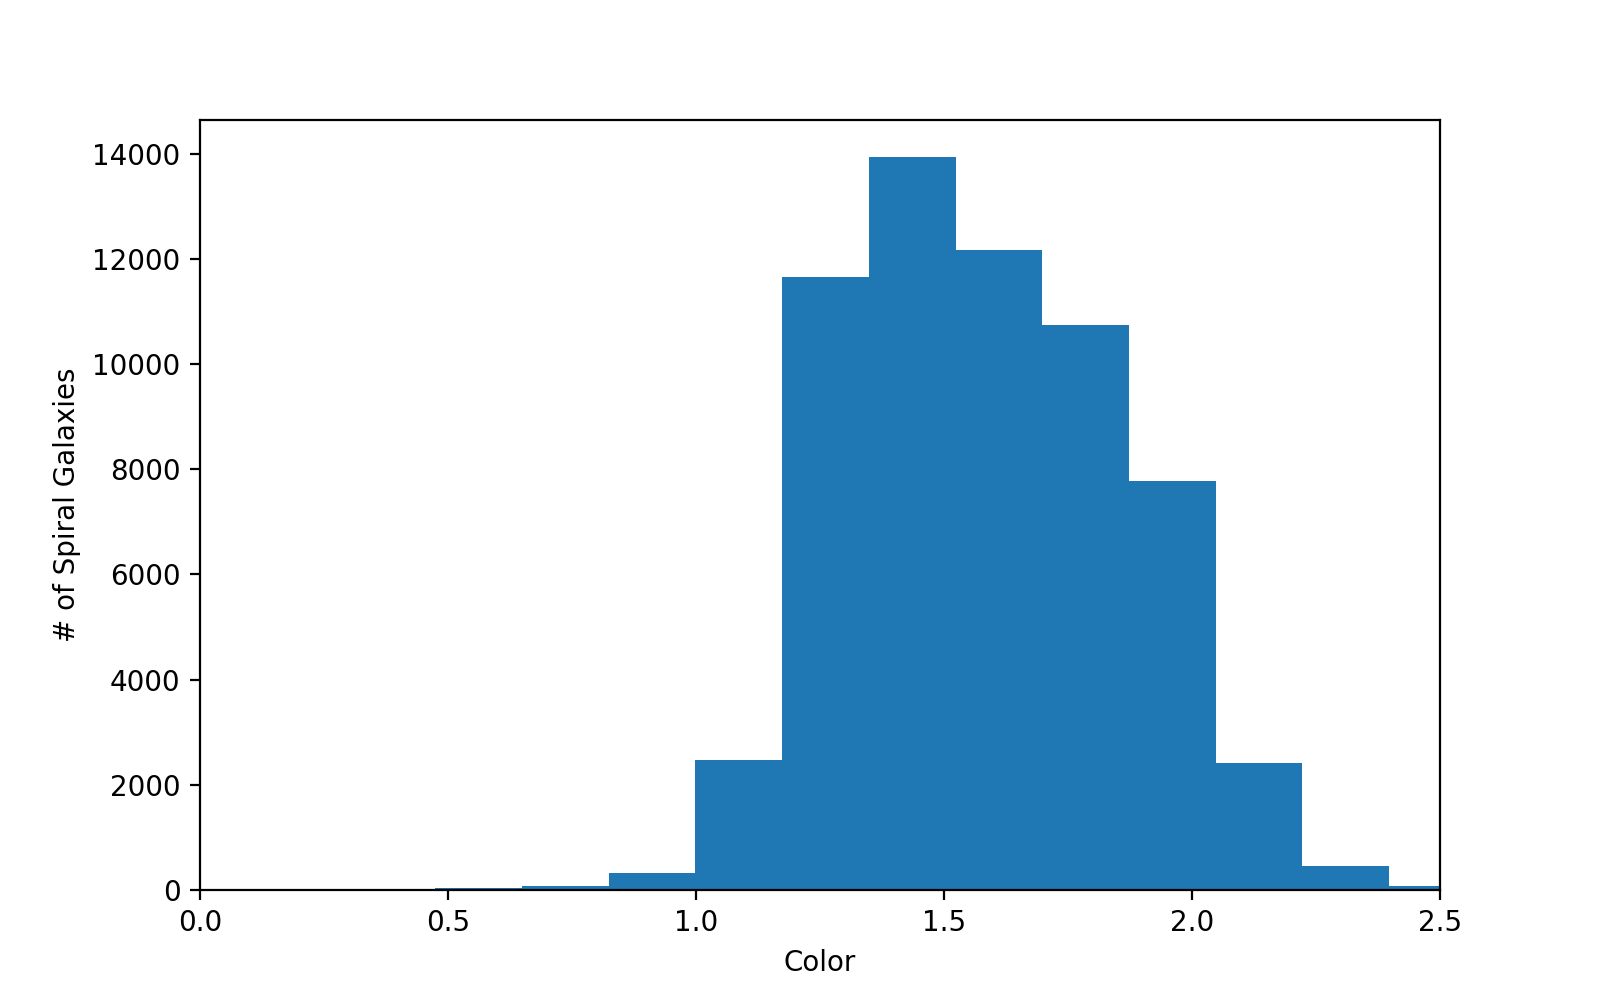

(0, 2.5)

In [61]:
# do the same but for the elliptical galaxies
f,ax = plt.subplots(figsize=(8,5))
plt.hist(elliptical_color[np.isfinite(elliptical_color)], bins=100)
ax.set_xlabel('Color')
ax.set_ylabel('# of Spiral Galaxies')
ax.set_xlim(0,2.5)

Compare the two plots.  Do you notice any difference?  Does one type of galaxy appear to be more red than the other?  Remember, the lower the value for color (g-i), the bluer the galaxy.  The bluer color indicates that the galaxy is currently making new star (i.e., has active star formation).

Lets plot both together to further illustrate the difference

<IPython.core.display.Javascript object>


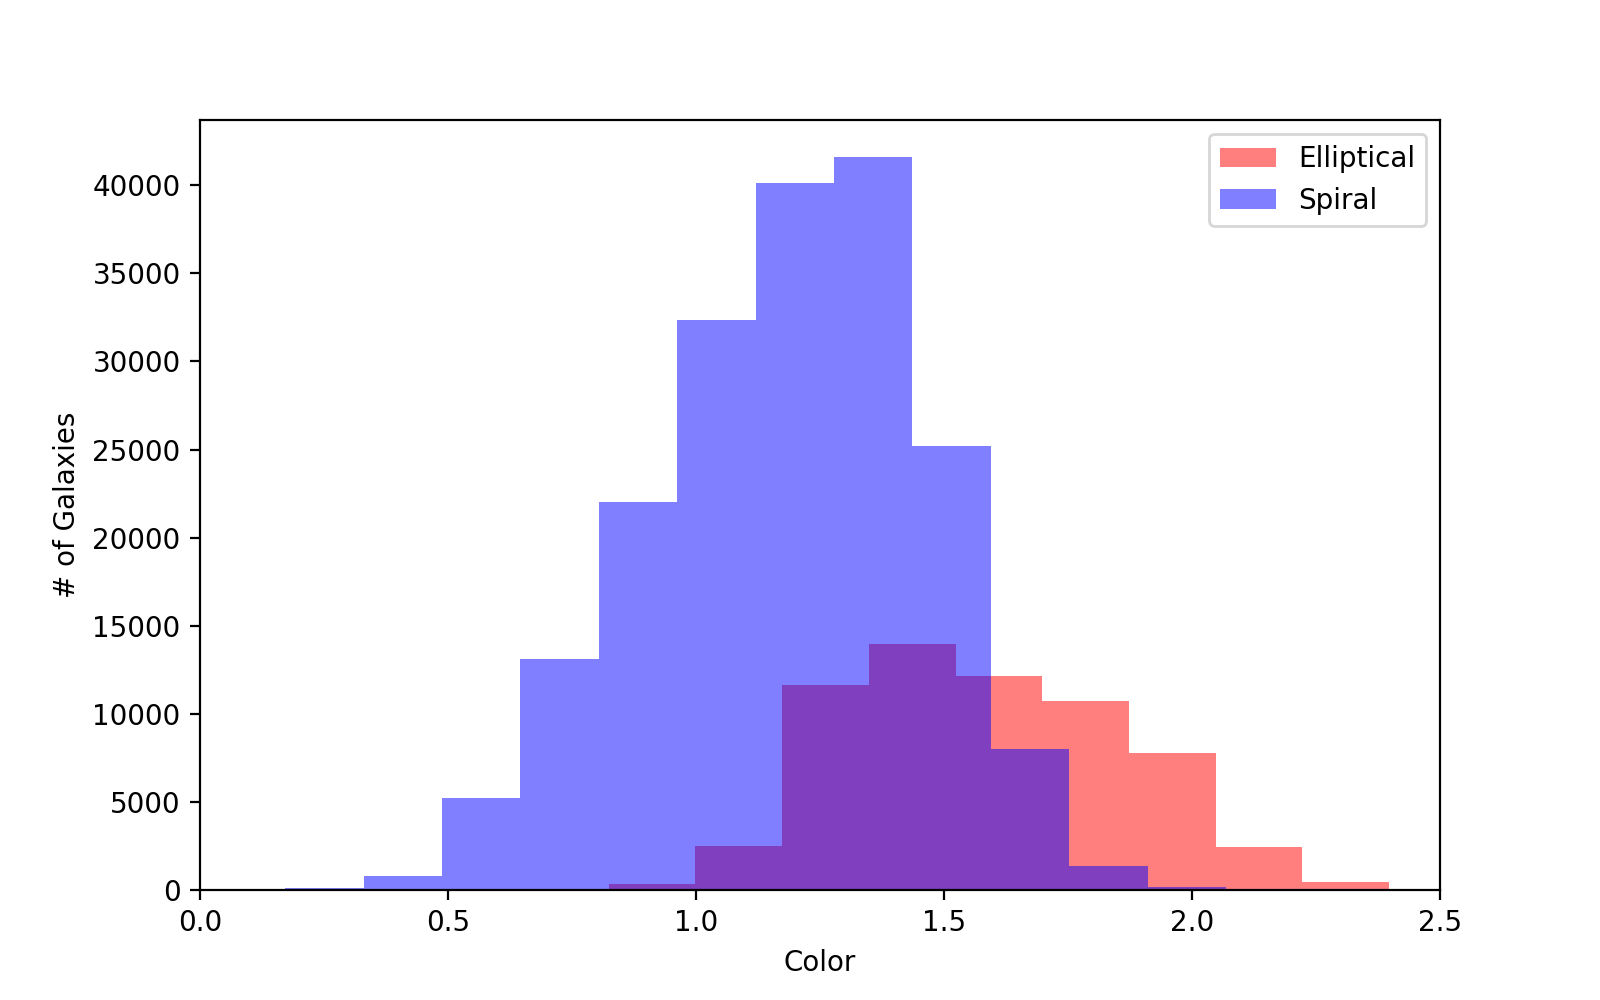

In [63]:
f,ax = plt.subplots(figsize=(8,5))

# give the bluer type a 'blue' color and the redder type a...
# also give the plots some transparency (using 'alpha') and a 'label'
plt.hist(elliptical_color[np.isfinite(elliptical_color)], bins=100, alpha=0.5, facecolor='red', label='Elliptical')
plt.hist(spiral_color[np.isfinite(spiral_color)], bins=100, alpha=0.5, facecolor='blue', label='Spiral')
ax.set_xlabel('Color')
ax.set_ylabel('# of Galaxies')
ax.set_xlim(0,2.5)

# add in a legend
ax.legend()

As we see, spiral galaxies tend to be bluer than elliptical.  Is this consistent with a blue color indicating current star formation?

However, also notice the exceptions. In your histogram, you see that a number of spiral galaxies are redder in color (have higher 'g-i' color values). These are galaxies where classifiers saw they had spiral arms, but their color tells us that they have no active star formation happening. <a href="http://www.sciencedaily.com/releases/2008/11/081124194936.htm">A special process has shut off star formation in these galaxies.</a> 

Finding this intriguing result was possible because of the huge numbers of galaxies in GalaxyZoo!

### 4. Examining an individual galaxy.

If you identify a subset of galaxies in the GalaxyZoo data table that you'd like to look at individually in more detail, you can do the following:

In [64]:
# query particular galaxies of interest, for example, red spirals
# note still need to avoid NAN values

redSpirals = np.where((Galaxies['Spiral'][np.isfinite(color)] == 1) & \
                      (color[np.isfinite(color)] < 1.91) & \
                      (color[np.isfinite(color)] > 1.9))[0]

print(f'# of red spirals = {len(redSpirals)}')

# print out where these are located
for i in redSpirals:
    print(f'RA, DEC = {RA[i]:7.5}, {DEC[i]:7.5}')

# of red spirals = 20
RA, DEC =  10.374,  13.821
RA, DEC =  11.004, -10.145
RA, DEC =  33.528,  14.055
RA, DEC =  112.46,    43.2
RA, DEC =  118.93,  33.107
RA, DEC =  130.73,  30.055
RA, DEC =  149.36,  25.598
RA, DEC =  151.63,  12.216
RA, DEC =  177.33,  14.059
RA, DEC =   195.9,  53.645
RA, DEC =  203.01, -2.3318
RA, DEC =  204.71,  65.611
RA, DEC =  210.09,  5.3911
RA, DEC =  217.38,  60.039
RA, DEC =  220.08,  21.331
RA, DEC =  227.84,   19.92
RA, DEC =  229.56,  48.289
RA, DEC =  313.76, -7.3872
RA, DEC =   342.8,  14.445
RA, DEC =  346.41,  14.457


#### Visualize these red spirals.

Now copy and paste these RA,Dec values into the <a href="http://skyserver.sdss.org/dr7/en/tools/chart/navi.asp">SDSS SkyServer finder chart</a>. You'll see an image of the galaxy of interest. <br>

Click on 'Quick Look' in the middle right of that page to get additional information about your galaxy.<br>

Do you see how they're red spirals?! Check out <a href="http://arxiv.org/abs/0910.4113">Dr. Karen Masters article on Red Spirals in Galaxy Zoo</a>.

***
<a id='sectionD'></a>
## D. Random Numbers

First let's talk about drawing values randomly in general.

Computers don't know how to draw truly random numbers. Instead they generate some large sequence of numbers that appear random, but are really deterministic. Usually you have to define a "seed" value to define where to start the sequence.

In python you don't actually have to define the "seed" value explicitly, but you can in order to keep your "random" draw the same each time you run the code.  

In general, we will use the numpy module to generate random numbers.

In [66]:
# Make sure the numpy module is loaded
import numpy as np

#Defining the "seed" for numpy's random function
np.random.seed(seed = 1234567)

Now, let's draw randomly from a Gaussian (aka 'Normal') distribution. <br>

In [70]:
#Numpy has a built-in function to draw random numbers from a Gaussian
#define the Gaussian using the mean, standard deviation (stdev), 
#  and choose some number of values (Nvals) that you want to draw
mean = 2.
stdev = 0.5
Nvals = 10000
rg = np.random.normal(mean, stdev, size = Nvals)

#print the mean, min and max of this list of random mumbers
print(f'mean,min,max of the random sample: {np.mean(rg)},{min(rg)},{max(rg)}')

mean,min,max of the random sample: 2.00181964826323,0.08062190163199578,4.203994797353353


<IPython.core.display.Javascript object>


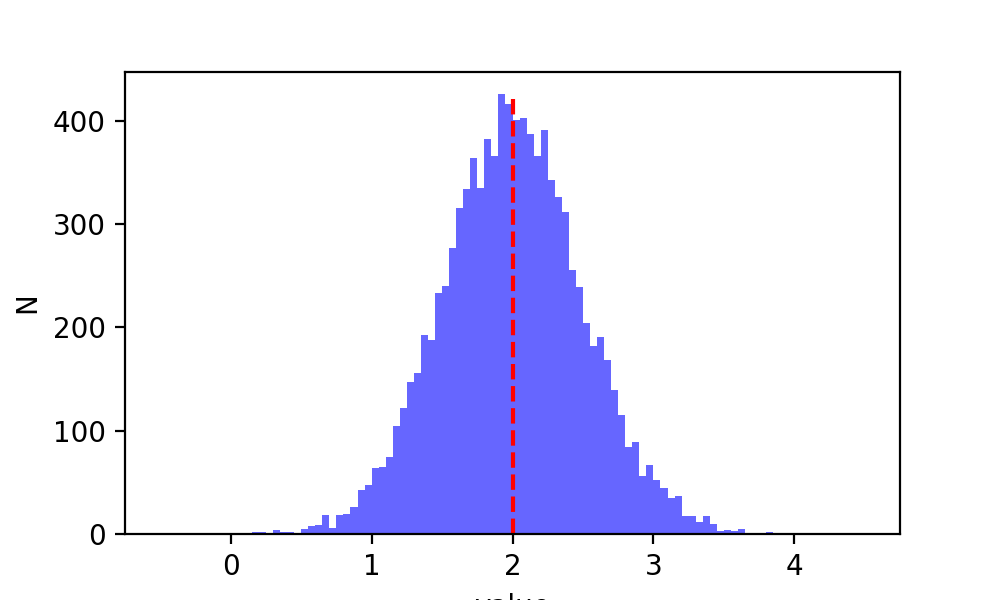

In [71]:
#plot a histogram of these values
f,ax = plt.subplots(figsize=(5,3))
n, bins, patches = ax.hist(rg, 100, color = 'b', alpha = 0.6, \
                       range = [mean - 5.*stdev, mean + 5.*stdev])

#overplot a dashed vertical line that shows the mean value
ax.plot([mean,mean],[0,max(n)], 'r--', linewidth = 1.5)

ax.set_xlabel("value")
ax.set_ylabel("N")

In [72]:
#How many values are within 1,2,3 sigma of the mean for this numpy.random.normal function?
#Hint: you can use numpy.where to find all the values that are within some range of the mean
print(f'np.random.normal:')
for fac in [1,2,3]:
    ntest = float(len(np.where( abs(rg - mean) < fac*stdev)[0]))
    print(f'    percent inside of {fac} times sigma = {ntest/float(Nvals)*100}')

np.random.normal:
    percent inside of 1 times sigma = 68.8
    percent inside of 2 times sigma = 95.23
    percent inside of 3 times sigma = 99.67


#### Question: Do the numbers for sigma match up to the <a href="http://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule">right answer for a gaussian distribution</a>?

If not exactly, why not? What could you change to get closer to the right answer? Make this change above, and see if you can come closer to the correct values.

In [73]:
#What if you didn't have this easy np.random.normal function?
#You could instead sample a Gaussian using this "Box-Muller" procedure 
#with two random numbers between 0 and 1. 
#In python you can draw numbers from a uniform distribution with np.random.random()
#This method is very useful, e.g., in C or fortran (and many othe codes)
rg_bm = []
for i in range(Nvals):
#draw your first random number
    x1 = np.random.random()
#draw your second random number    
    x2 = np.random.random()
#just in case we drew 0
    while (x1 == 0): x1 = np.random.random()
    while (x2 == 0): x2 = np.random.random()
#this draws from a Guassian distribution
    rg_bm.append(stdev * (-2.*np.log(x1))**0.5 * np.cos(2.*np.pi*x2) + mean)
    
rg_bm = np.array(rg_bm) #just to keep them in the same format

In [74]:
#How many values are within 1,2,3 sigma for the "Box-Muller" procedure?
print(f'Box-Muller :')
for fac in [1,2,3]:
    ntest = float(len(np.where( abs(rg_bm - mean) < fac*stdev)[0]))
    print(f'    percent inside of {fac} times sigma = {ntest/float(Nvals)*100}')

Box-Muller :
    percent inside of 1 times sigma = 68.57
    percent inside of 2 times sigma = 95.73
    percent inside of 3 times sigma = 99.66000000000001


<IPython.core.display.Javascript object>


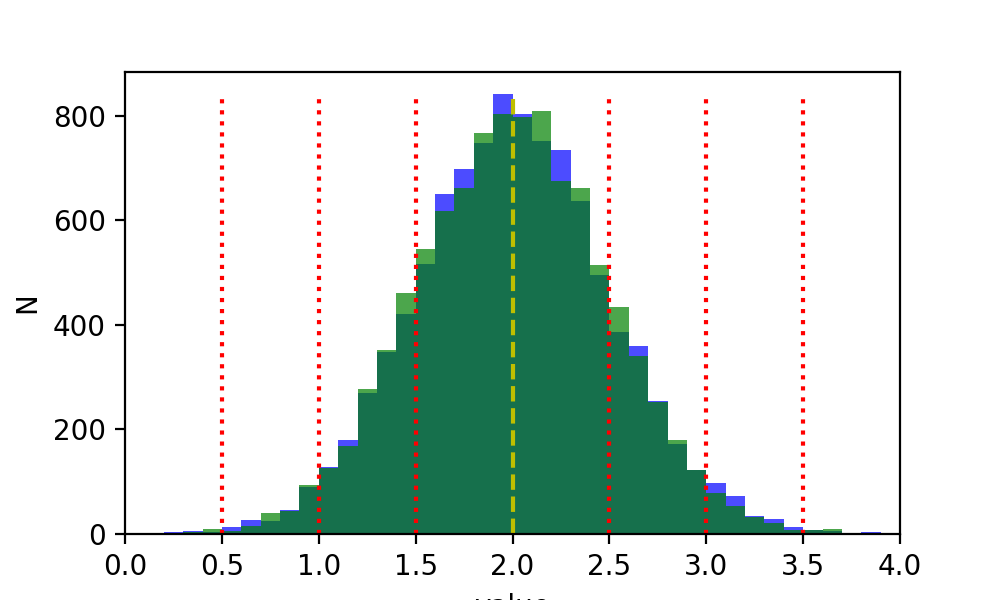

(0, 4)

In [79]:
#plot a histogram of these values
f,ax = plt.subplots(figsize=(5,3))
#first the numpy.random.normal results
n, bins, patches = ax.hist(rg, 50, color = 'b', alpha = 0.7, \
                           range = [mean - 5.*stdev, mean + 5.*stdev])
#now the Box-Muller results
nb, binsb, patchesb = ax.hist(rg_bm, 50, color = 'g', alpha = 0.7, \
                            range = [mean - 5.*stdev, mean + 5.*stdev])

#overplot a dashed line that shows the mean value
ax.plot([mean,mean], [0,max(n)],'y--')

#overplot dotted lines that show the 1,2,3 sigma values
for fac in [1,2,3]:
    ax.plot([mean + fac*stdev, mean + fac*stdev],[0,max(n)], 'r:', linewidth = 1.5)
    ax.plot([mean - fac*stdev, mean - fac*stdev],[0,max(n)], 'r:', linewidth = 1.5)

    
ax.set_xlabel("value")
ax.set_ylabel("N")
ax.set_xlim(0,4)

# Congratulations! You've completed part 2!